In [1]:
# matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# pandas
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# numpy
import numpy as np
# keras; not sure which version
# API changes frequently, so...
import keras
from keras.models import Sequential                                     
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasRegressor
# from keras.layers.normalization import BatchNormalization
# from keras.optimizers import SGD        
# from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# normal
import time
import os

Using TensorFlow backend.


# Load dataset

In [2]:
# load dataset
dataframe = pd.read_csv("housing.csv", delim_whitespace=True, header=None,
                        names=['crim', 'zn', 'indus', 'chas', 'nox',
                               'rm', 'age', 'dis', 'rad', 'tax',
                               'ptratio', 'black', 'lstat', 'medv'])
dataset = dataframe.values
dataframe.head()

crim     zn  indus  chas   nox    rm    age   dis  rad     tax  ptratio  \
0 0.006 18.000  2.310     0 0.538 6.575 65.200 4.090    1 296.000   15.300   
1 0.027  0.000  7.070     0 0.469 6.421 78.900 4.967    2 242.000   17.800   
2 0.027  0.000  7.070     0 0.469 7.185 61.100 4.967    2 242.000   17.800   
3 0.032  0.000  2.180     0 0.458 6.998 45.800 6.062    3 222.000   18.700   
4 0.069  0.000  2.180     0 0.458 7.147 54.200 6.062    3 222.000   18.700   

    black  lstat   medv  
0 396.900  4.980 24.000  
1 396.900  9.140 21.600  
2 392.830  4.030 34.700  
3 394.630  2.940 33.400  
4 396.900  5.330 36.200

In [3]:
dataframe.describe()

crim      zn   indus    chas     nox      rm     age     dis     rad  \
count 506.000 506.000 506.000 506.000 506.000 506.000 506.000 506.000 506.000   
mean    3.614  11.364  11.137   0.069   0.555   6.285  68.575   3.795   9.549   
std     8.602  23.322   6.860   0.254   0.116   0.703  28.149   2.106   8.707   
min     0.006   0.000   0.460   0.000   0.385   3.561   2.900   1.130   1.000   
25%     0.082   0.000   5.190   0.000   0.449   5.886  45.025   2.100   4.000   
50%     0.257   0.000   9.690   0.000   0.538   6.208  77.500   3.207   5.000   
75%     3.677  12.500  18.100   0.000   0.624   6.623  94.075   5.188  24.000   
max    88.976 100.000  27.740   1.000   0.871   8.780 100.000  12.127  24.000   

          tax  ptratio   black   lstat    medv  
count 506.000  506.000 506.000 506.000 506.000  
mean  408.237   18.456 356.674  12.653  22.533  
std   168.537    2.165  91.295   7.141   9.197  
min   187.000   12.600   0.320   1.730   5.000  
25%   279.000   17.400 375.377   6.950  17.025  
50%   330.000   19.050 391.440  11.360  21.200  
75%   666.000   20.200 396.225  16.955  25.000  
max   711.000   22.000 396.900  37.970  50.000

Let's start getting a feel for the data, starting by evaluating suspicious values

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'],
      dtype='object')


<IPython.core.display.Javascript object>


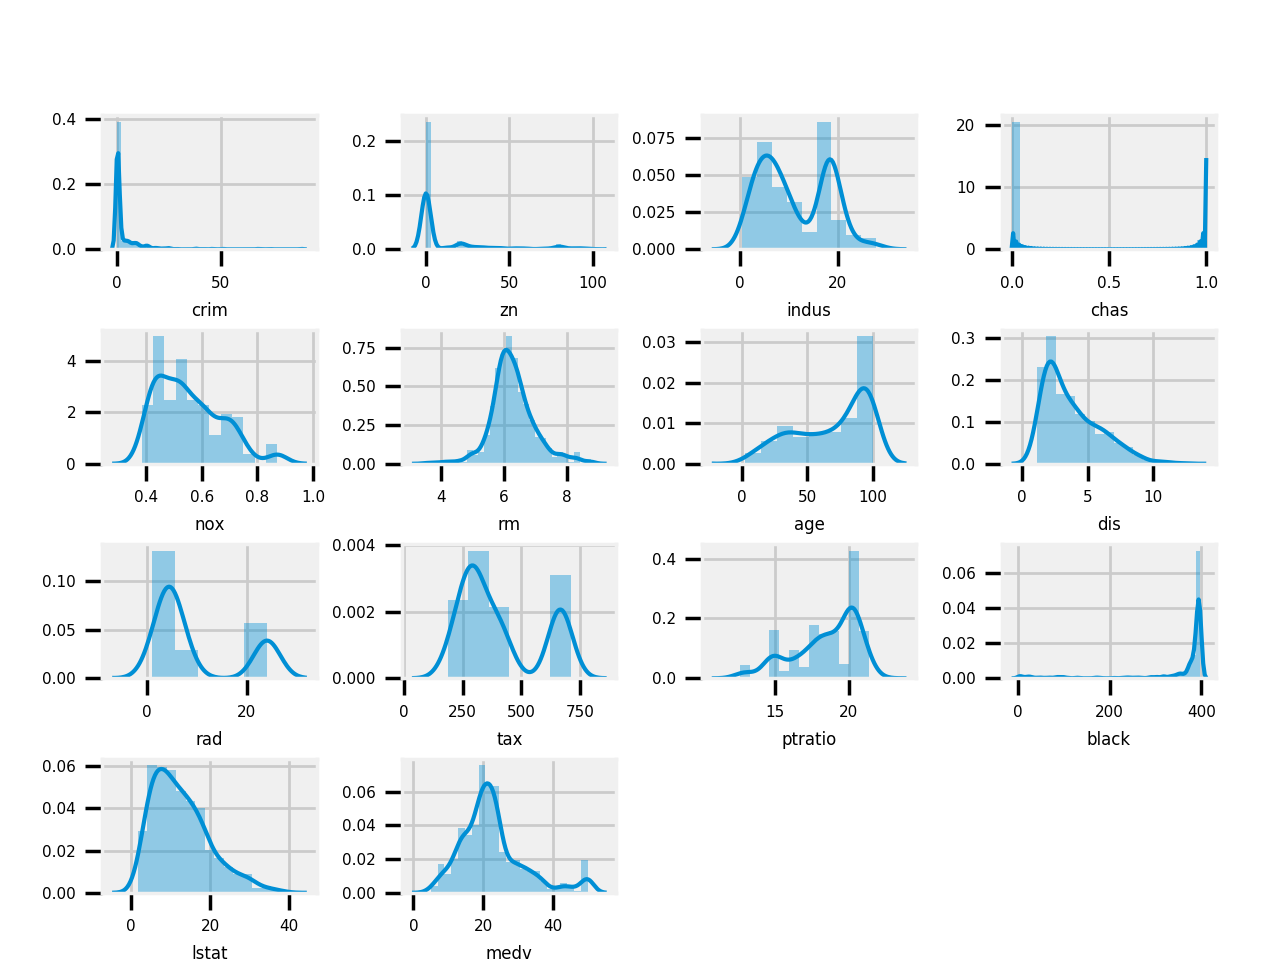

In [12]:
import seaborn as sns
# we have 14 columns...we'll use an unfilled
# 4x4 array
print(dataframe.columns[:13])
sns.set_context("notebook", font_scale=0.5)
fig = plt.figure()
for i, c in enumerate(dataframe.columns):
    ax = fig.add_subplot(4, 4, i+1)
    sns.distplot(dataframe[c], ax=ax)
#     ax.set_xticks(fontsize=10)
fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()
# sns.distplot()

Focus on:

- `chas`
- `zn`
- `age`
- `medv`

<IPython.core.display.Javascript object>


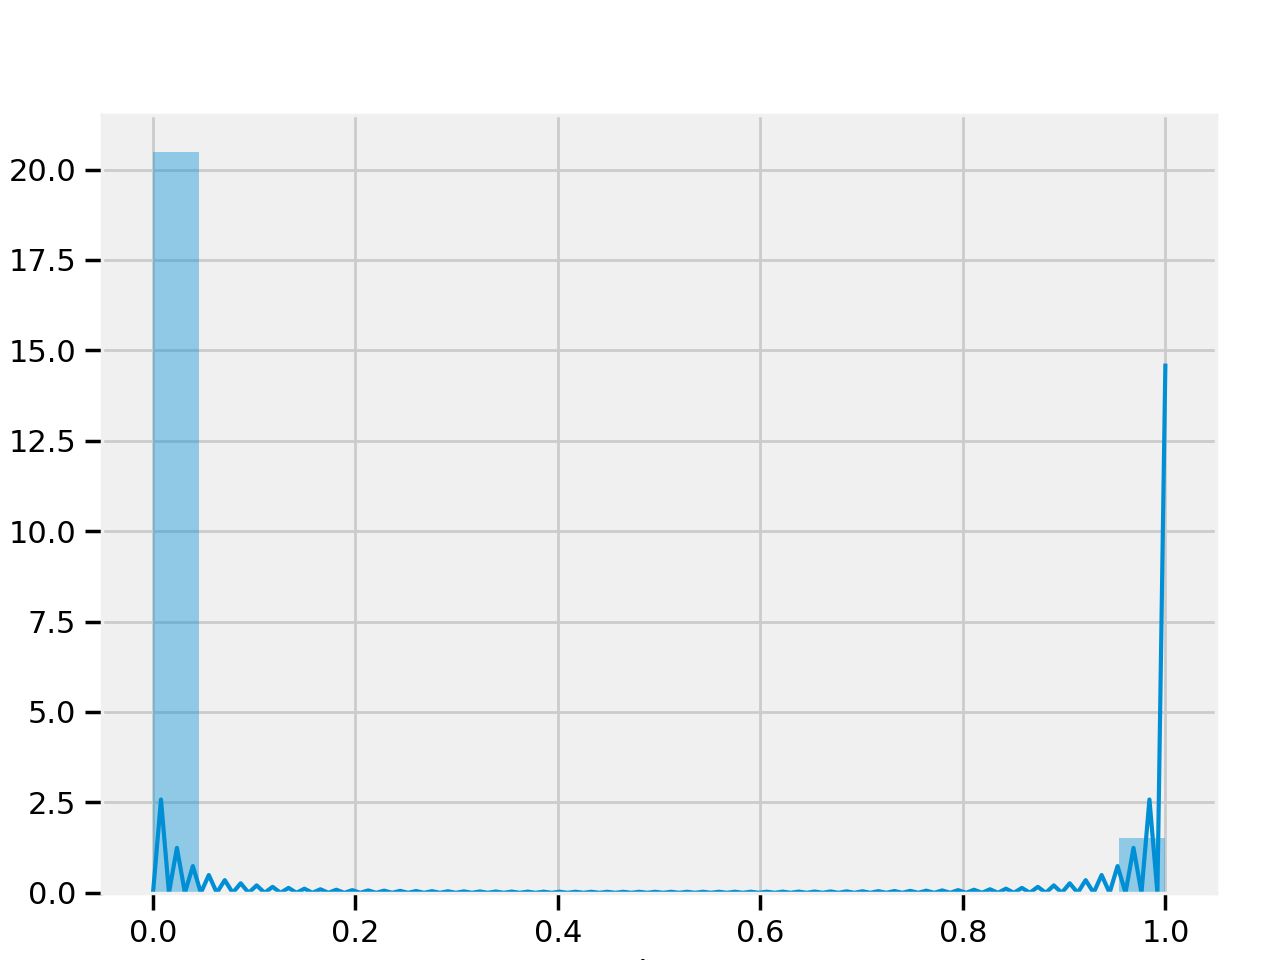

<IPython.core.display.Javascript object>


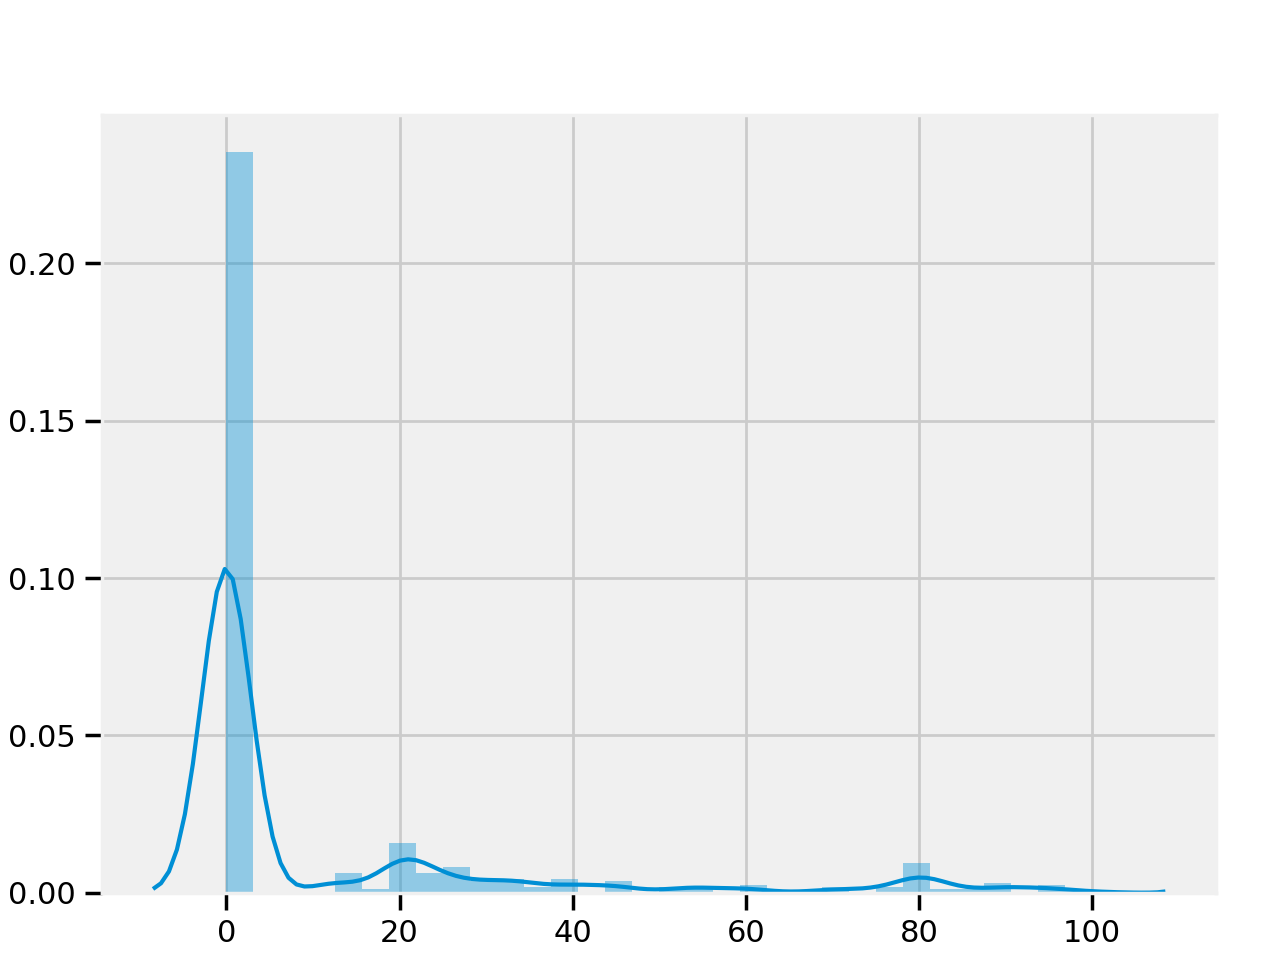

<IPython.core.display.Javascript object>


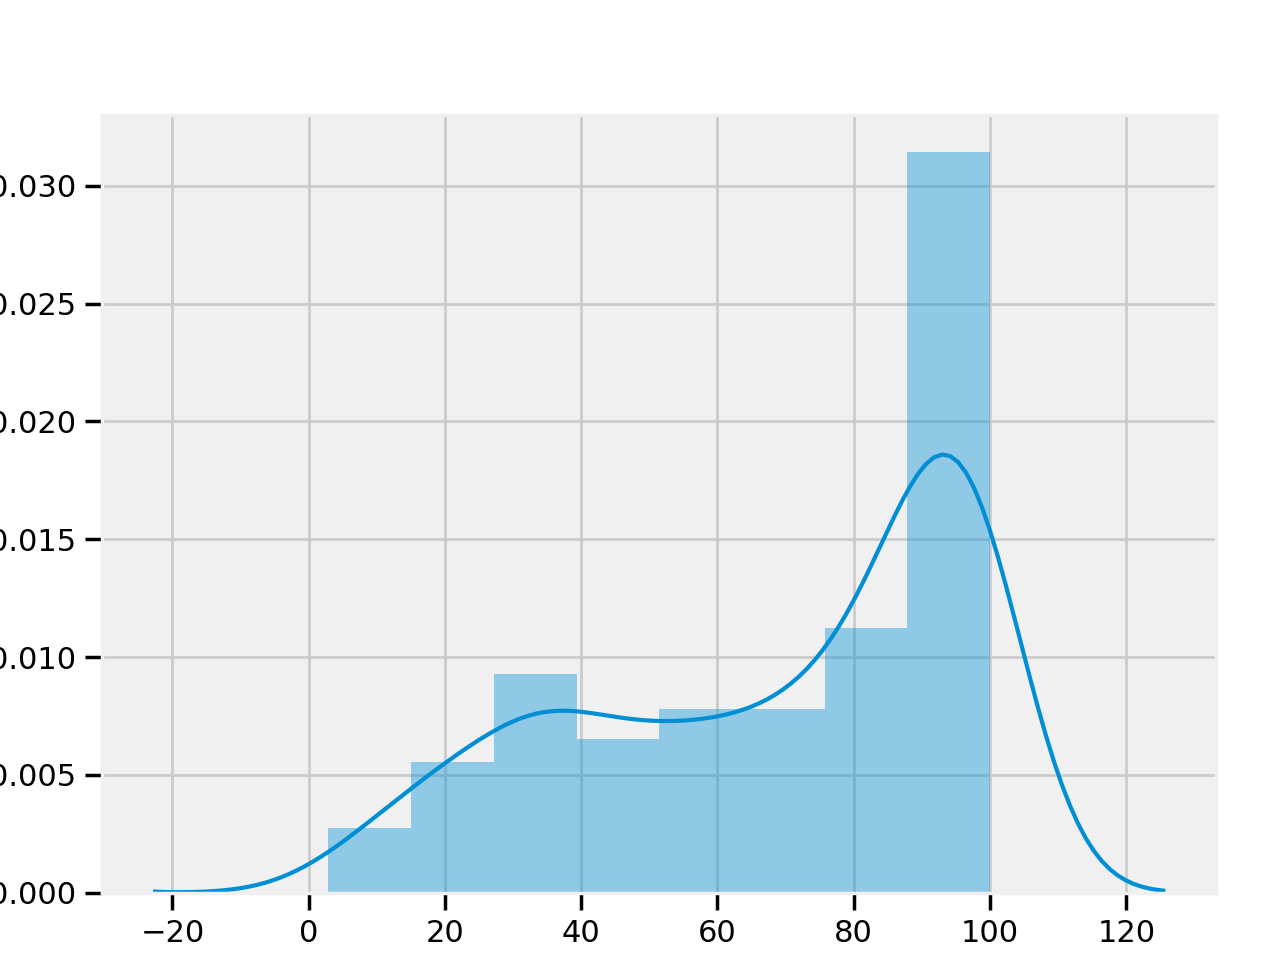

<IPython.core.display.Javascript object>


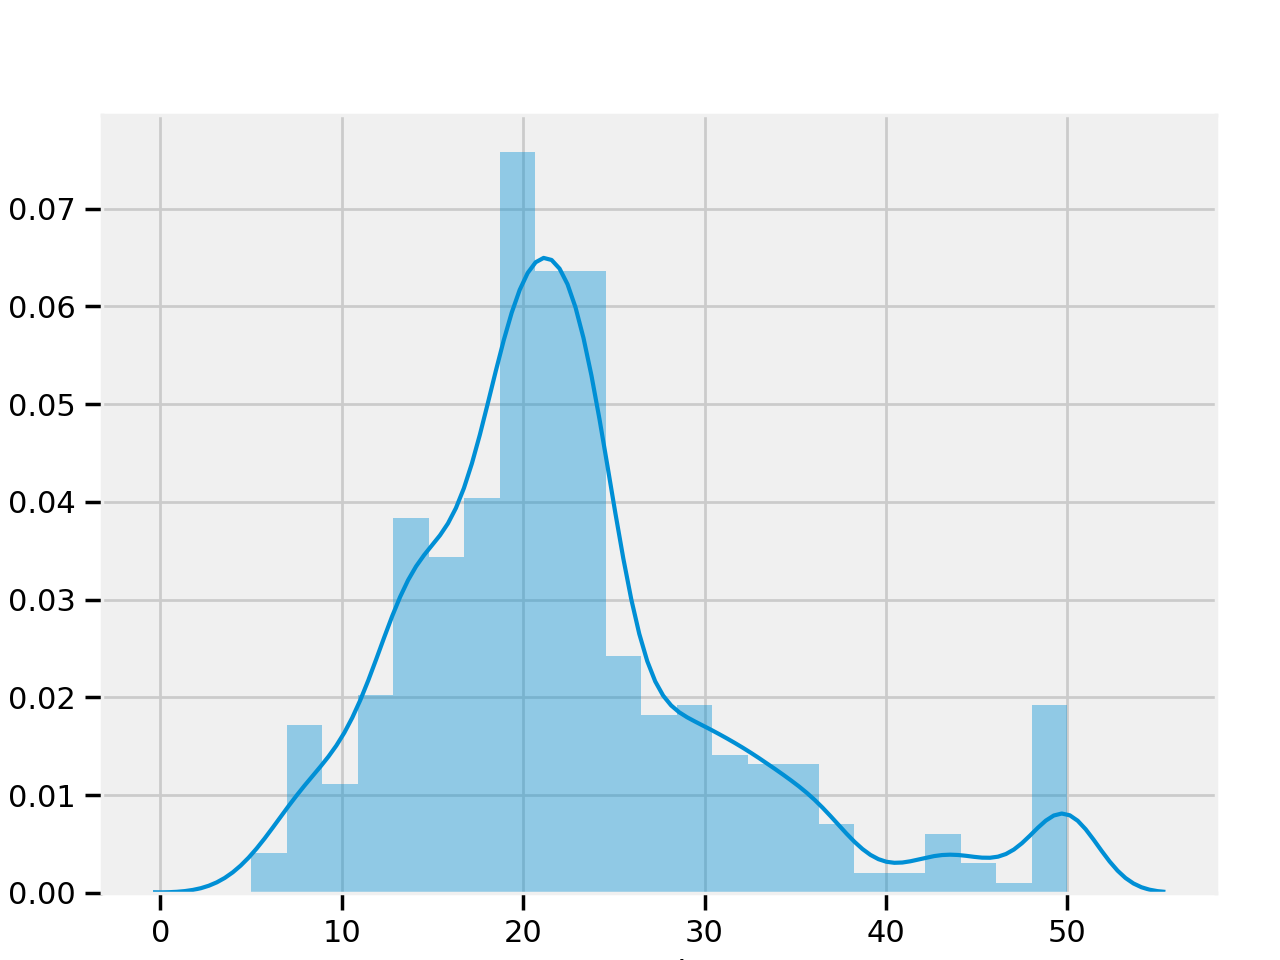

In [13]:
sns.set_context("notebook", font_scale=1.0)
for i, c in enumerate(['chas', 'zn', 'age', 'medv']):
    fig = plt.figure()
    sns.distplot(dataframe[c])
plt.show()
# sns.distplo

There are no obvious outliers or data to clean/ignore.

Let's do a correlation analysis

<IPython.core.display.Javascript object>


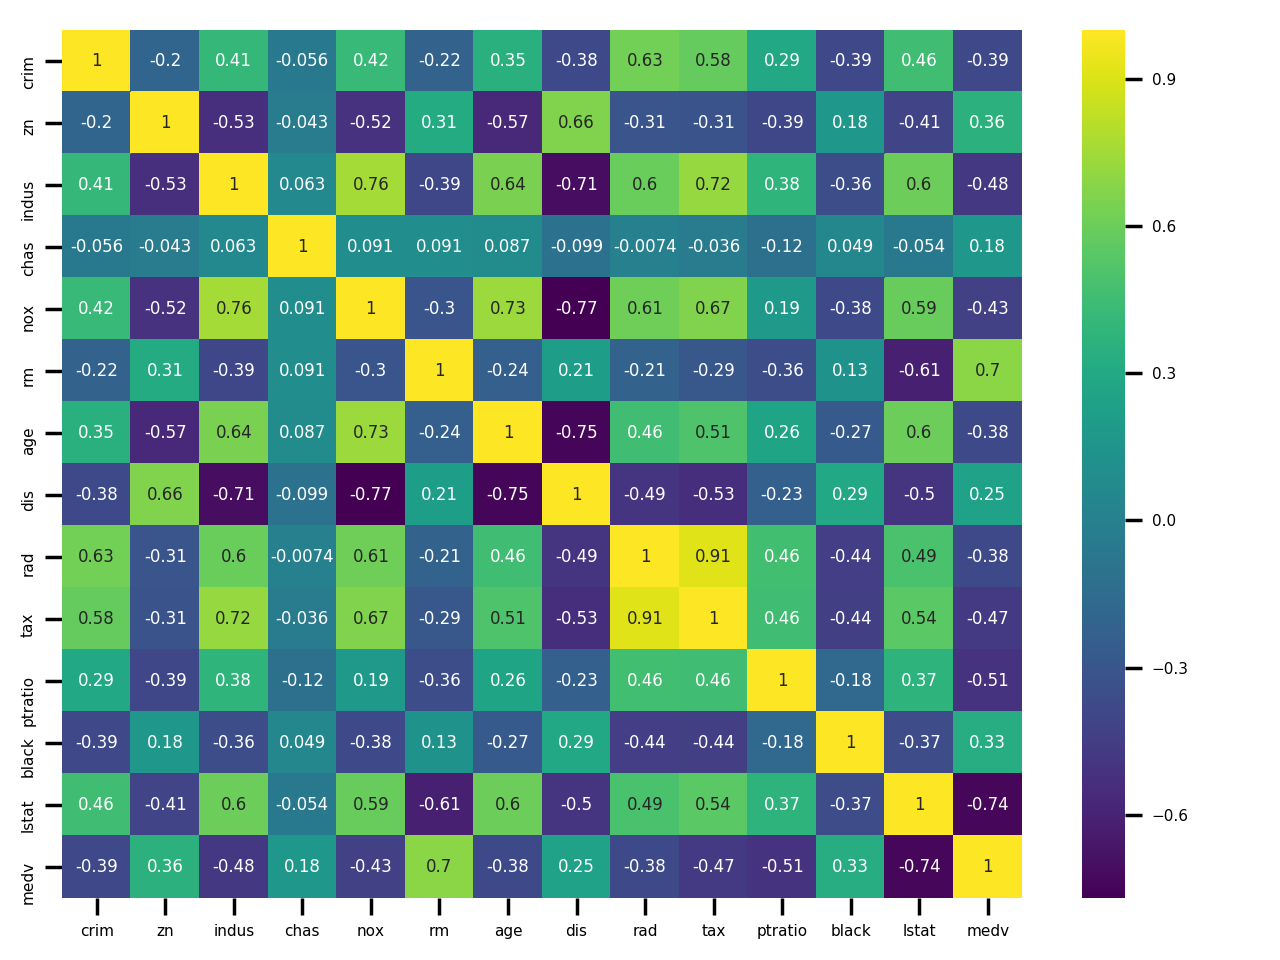

In [17]:
corr = dataframe.corr()
sns.set_context("notebook", font_scale=0.5)
plt.figure()
sns.heatmap(corr, annot=True, cmap='viridis')
plt.tight_layout()
plt.show()

In [19]:
import scipy.special
print(scipy.special.binom(13, 2))

78.0


rather than do our pair plotting, we need to see what, if any, correlation, our independent variables have on our dependent variable

<IPython.core.display.Javascript object>


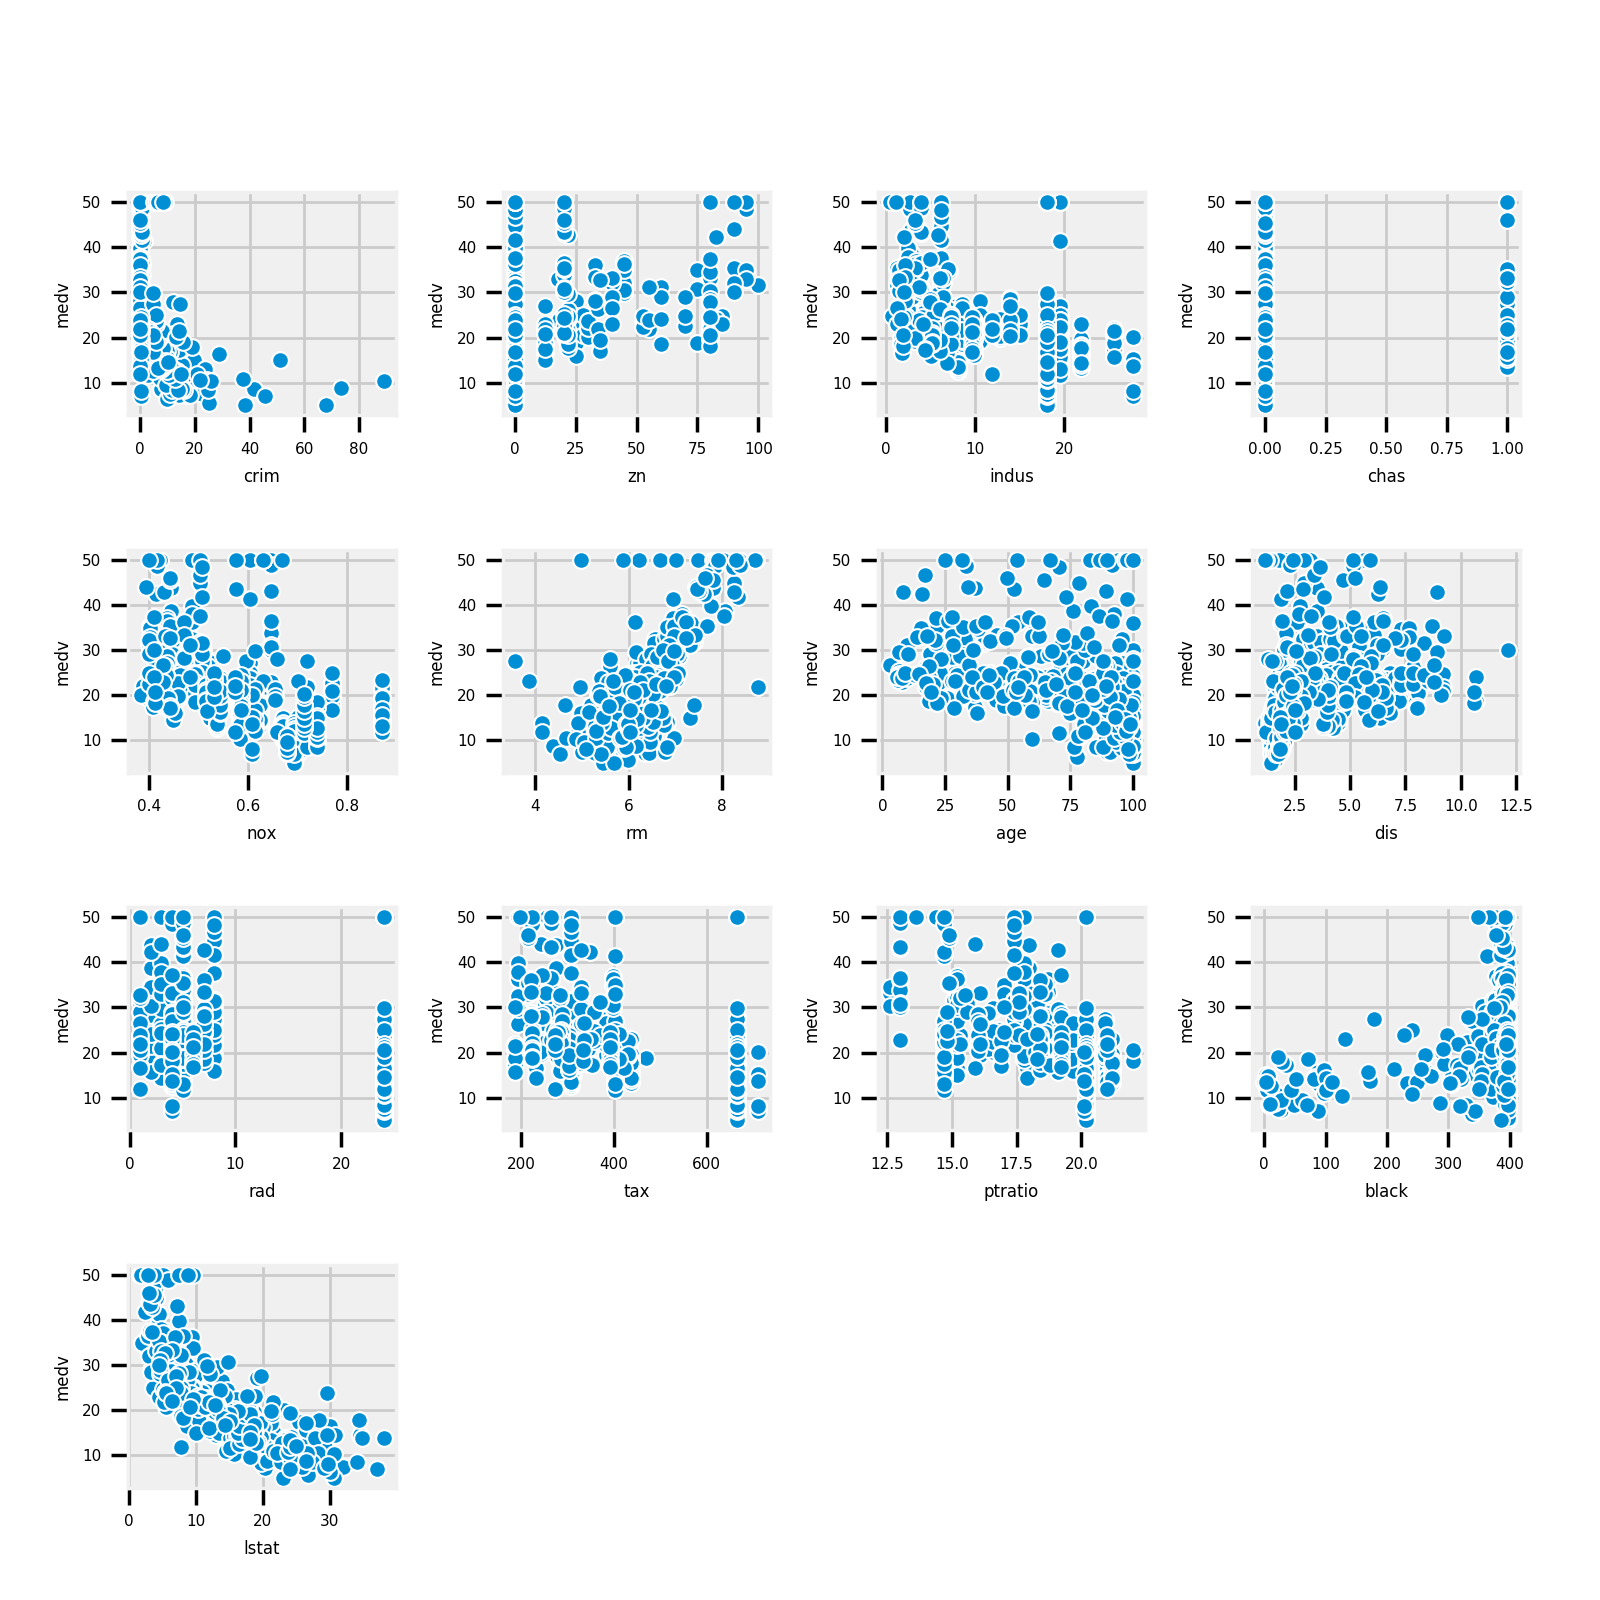

In [24]:
# this is a cool one-liner...but not what we need
# sns.pairplot(dataframe)
sns.set_context("notebook", font_scale=0.5)
fig = plt.figure(figsize=(8,8))
for i, c in enumerate(dataframe.columns[:13]):
    ax = fig.add_subplot(4, 4, i+1)
    sns.scatterplot(dataframe[c], dataframe['medv'], ax=ax)
#     ax.set_xticks(fontsize=10)
fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

# Start with a linear regression to set a baseline

In [250]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

X_train, X_valid, y_train, y_valid = train_test_split(dataframe.drop(columns=['medv']), np.array(dataframe['medv']), 
                                                      random_state = 42, test_size = 100)
# use all the data
lr.fit(X_train, y_train)

print('Intercept', round(lr.intercept_, 4))

Intercept 30.1555


In [251]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [252]:
evaluate(lr, dataframe.columns[:13],
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.64 	 mape = 16.52
Validation: rmse = 4.96 	 mape = 17.0


In [253]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 9.3 	 mape = 36.62
Baseline Validation: rmse = 8.75 	 mape = 38.34


We're beating the mean!

<IPython.core.display.Javascript object>


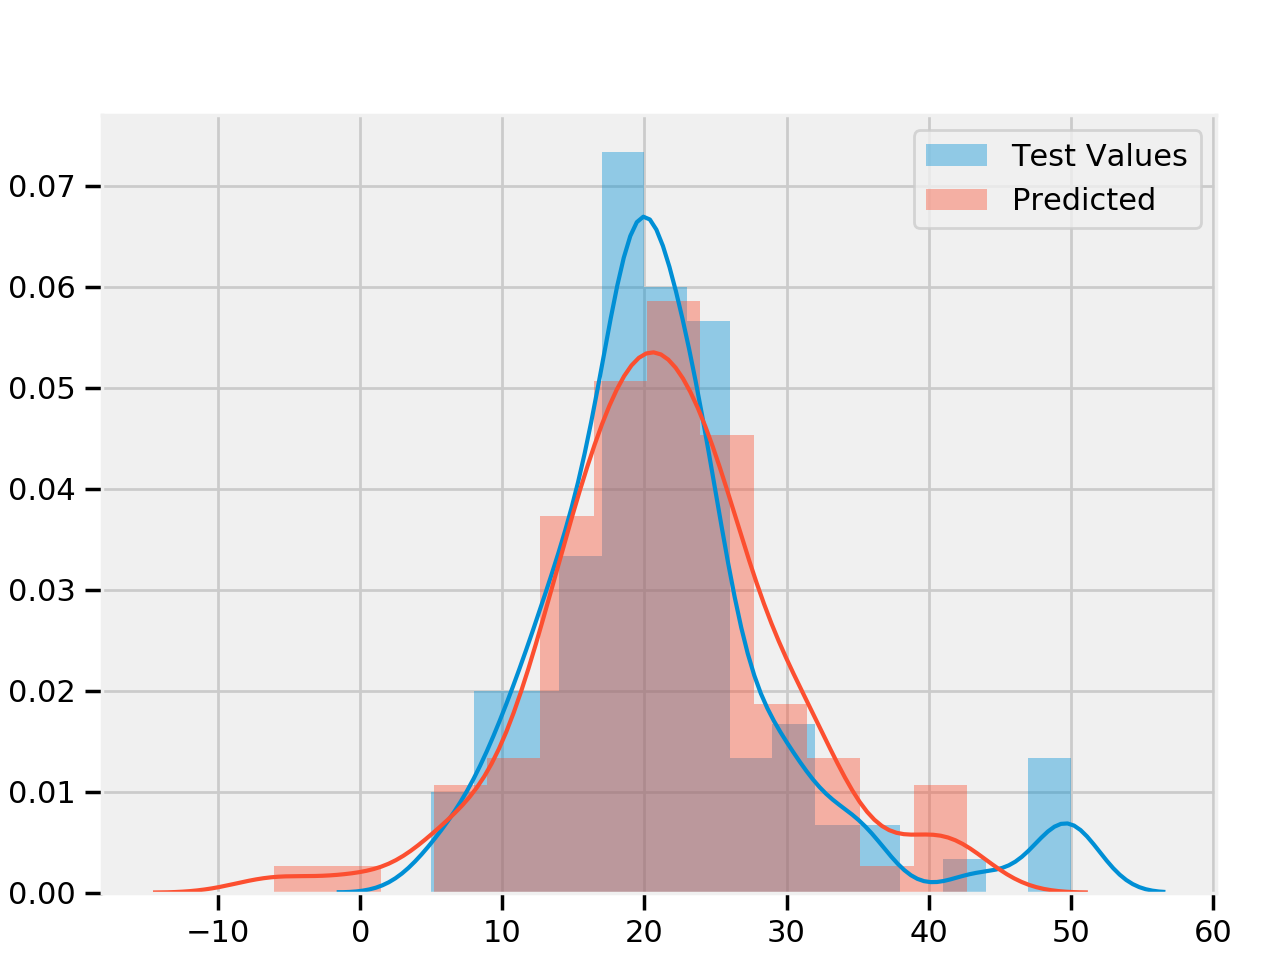

In [254]:
y_preds = lr.predict(X_valid)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

alternate view of the regression

<IPython.core.display.Javascript object>


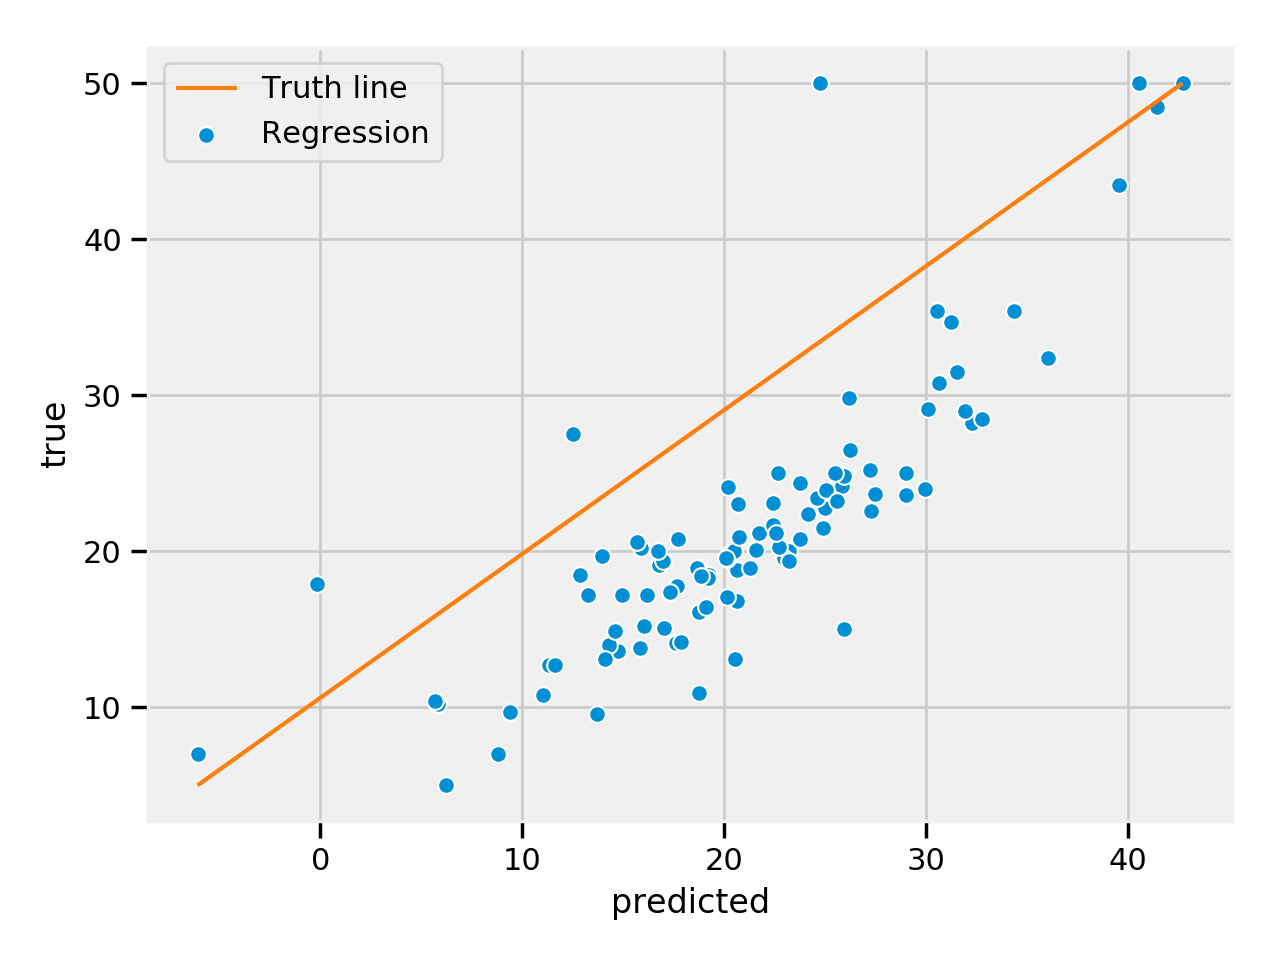

In [255]:
y_pred = lr.predict(X_valid)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred, y_valid,
                ax=ax, label='Regression')
ax.plot([np.nanmin(y_preds), np.nanmax(y_preds)],
         [np.nanmin(y_valid), np.nanmax(y_valid)],
        label='Truth line', color='tab:orange')
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

Note that the regression is systematically over-estimating the values...

Let's try to improve (note, we can't use our old standby, the confusion matrix here)

# Support vector regression

In [256]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_train, y_train)
evaluate(model, dataframe.columns[:13],
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 8.6 	 mape = 28.4
Validation: rmse = 8.55 	 mape = 33.61


<IPython.core.display.Javascript object>


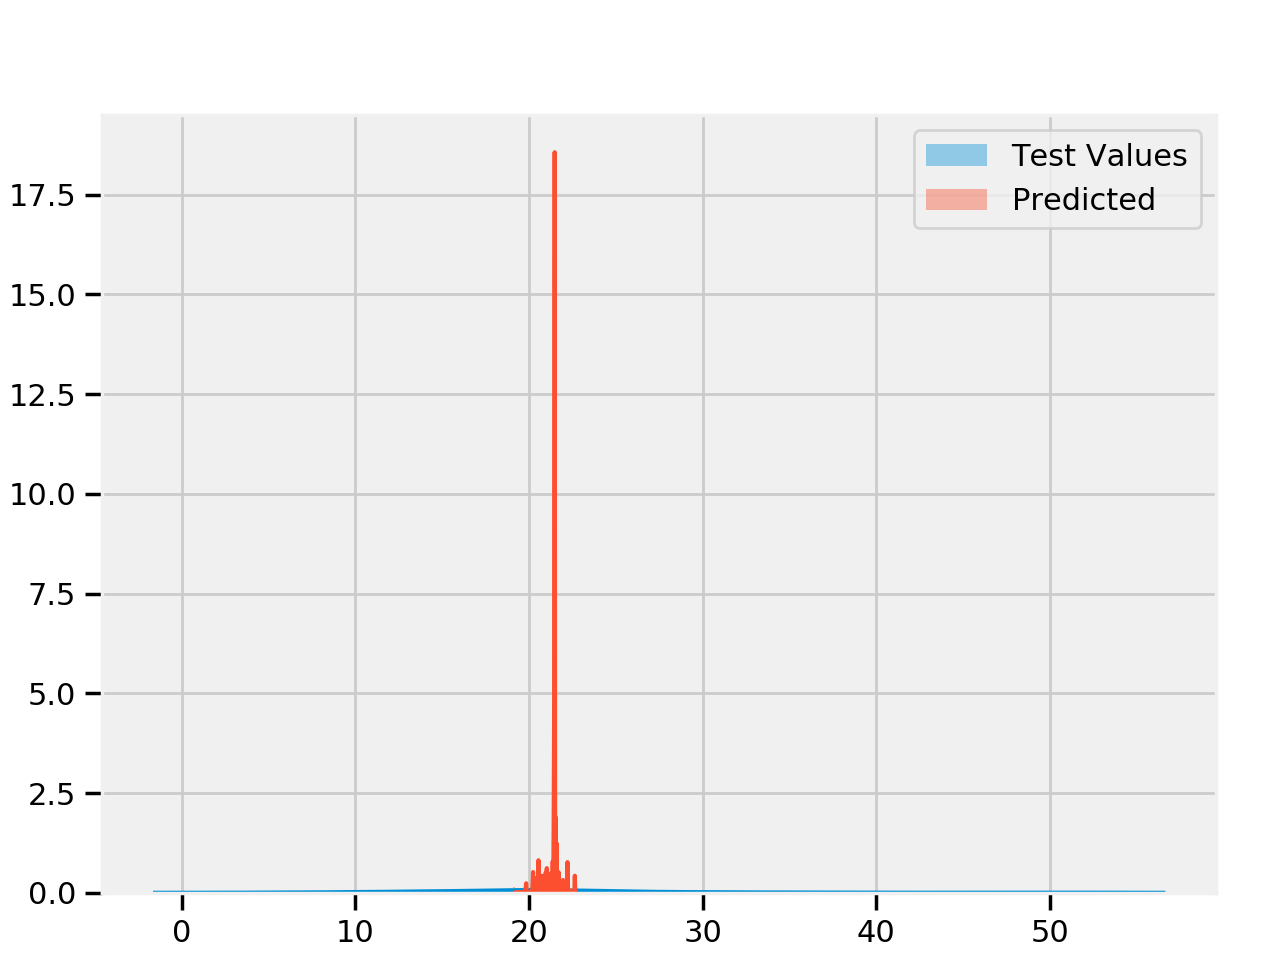

In [257]:
y_preds = model.predict(X_valid)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

well...that's bad. Probably should scale our data



In [258]:
# model = SVR()
# model = SVR(kernel='rbf', C=1)
model = SVR(kernel='rbf', C=10, gamma=0.1)
scaler = StandardScaler()
scaler.fit(X_train)
model.fit(scaler.transform(X_train), y_train)
X_train_scaled = X_train
X_valid_scaled = X_valid
X_train_scaled[X_train_scaled.columns] = scaler.transform(X_train_scaled[X_train_scaled.columns])
X_valid_scaled[X_train_scaled.columns] = scaler.transform(X_valid[X_train_scaled.columns])
evaluate(model, dataframe.columns[:13],
         X_train_scaled, X_valid_scaled, y_train, y_valid)

Training:   rmse = 2.75 	 mape = 6.71
Validation: rmse = 3.67 	 mape = 11.6


<IPython.core.display.Javascript object>


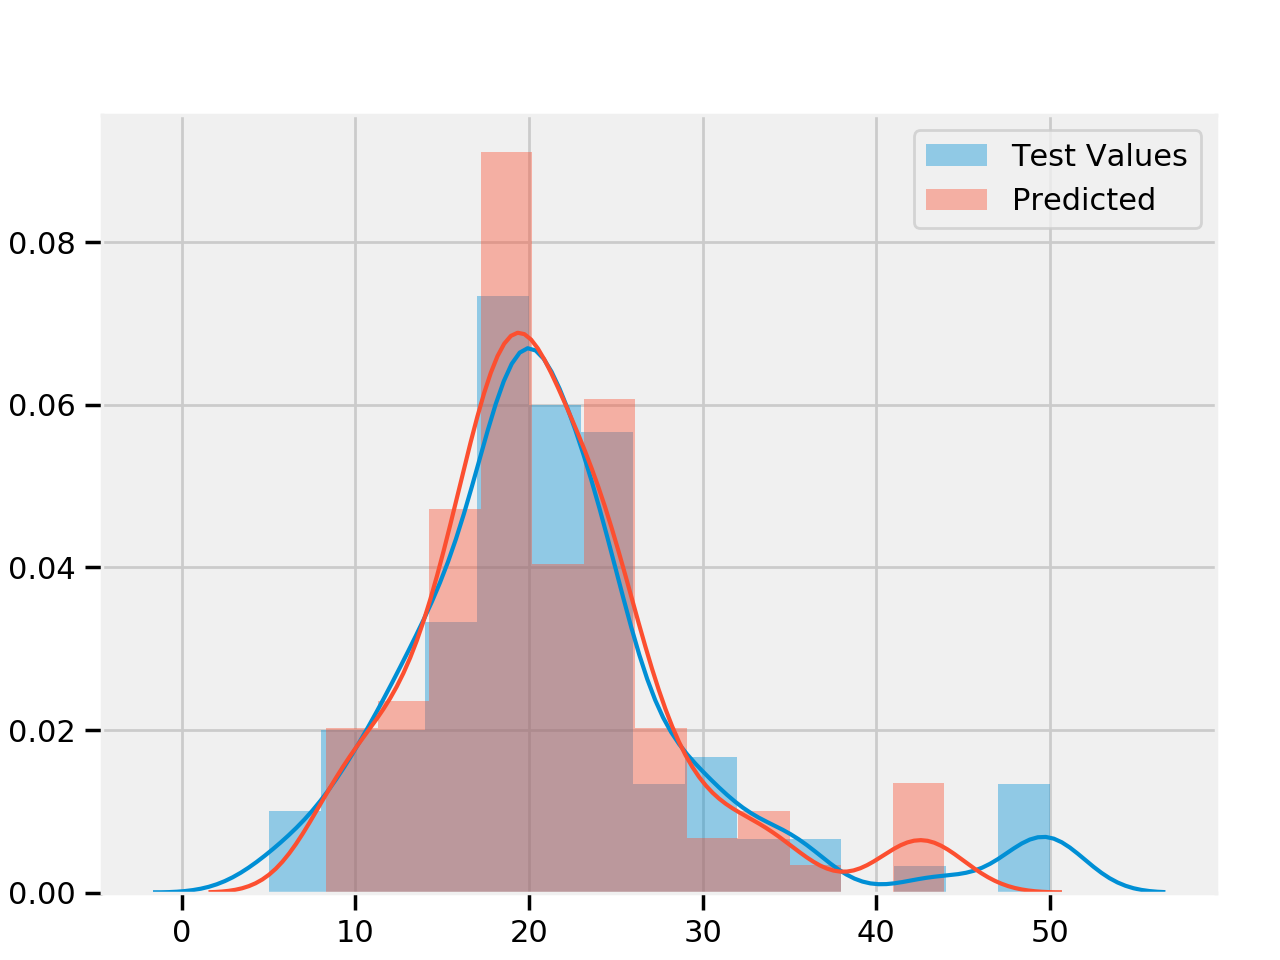

In [259]:
y_pred = model.predict(X_valid_scaled)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_pred, label="Predicted")
plt.legend()

<IPython.core.display.Javascript object>


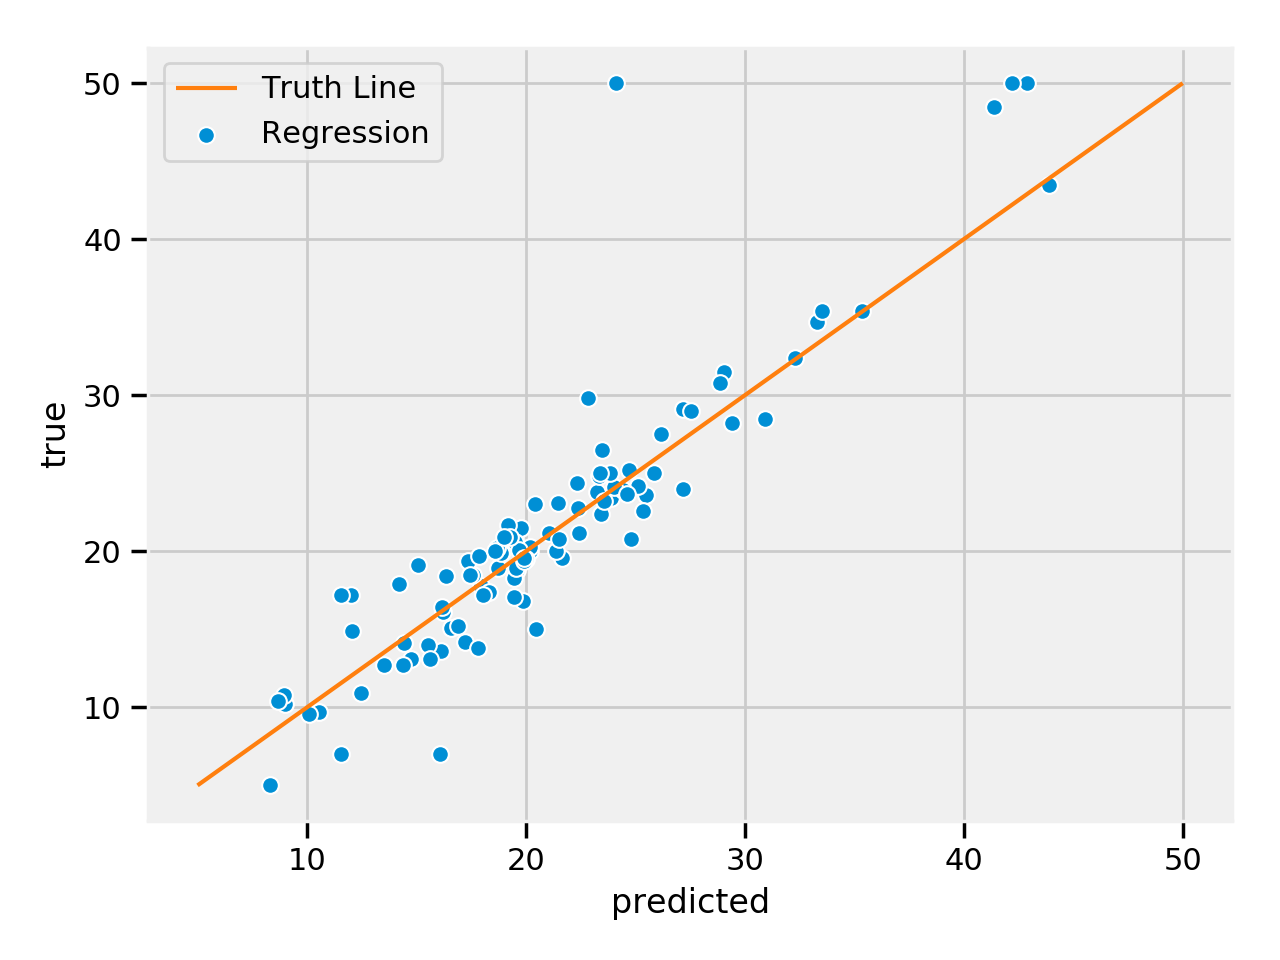

In [261]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

That was very simple, let's try a hyperparameter sweep

Maybe now we do a hyperparameter sweep?

In [262]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(SVR(kernel='rbf', gamma=0.1, epsilon=0.1), cv=5,
                     param_grid=dict(C=[1, 5, 10, 50, 100, 500, 1000],
                                     gamma=np.logspace(-2, 2, 10),
                                     epsilon=np.logspace(-2, 2, 10)))
scaler = StandardScaler()
scaler.fit(X_train)
t0 = time.time()
model.fit(scaler.transform(X_train), y_train)
t1 = time.time()
print(f"time to optimize: {t1-t0}")

time to optimize: 38.74737477302551


In [263]:
evaluate(model, dataframe.columns[:13],
         X_train_scaled, X_valid_scaled, y_train, y_valid)
print(model.best_estimator_)

Training:   rmse = 1.58 	 mape = 5.19
Validation: rmse = 3.52 	 mape = 11.32
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.59948425031894093,
  gamma=0.077426368268112694, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)


<IPython.core.display.Javascript object>


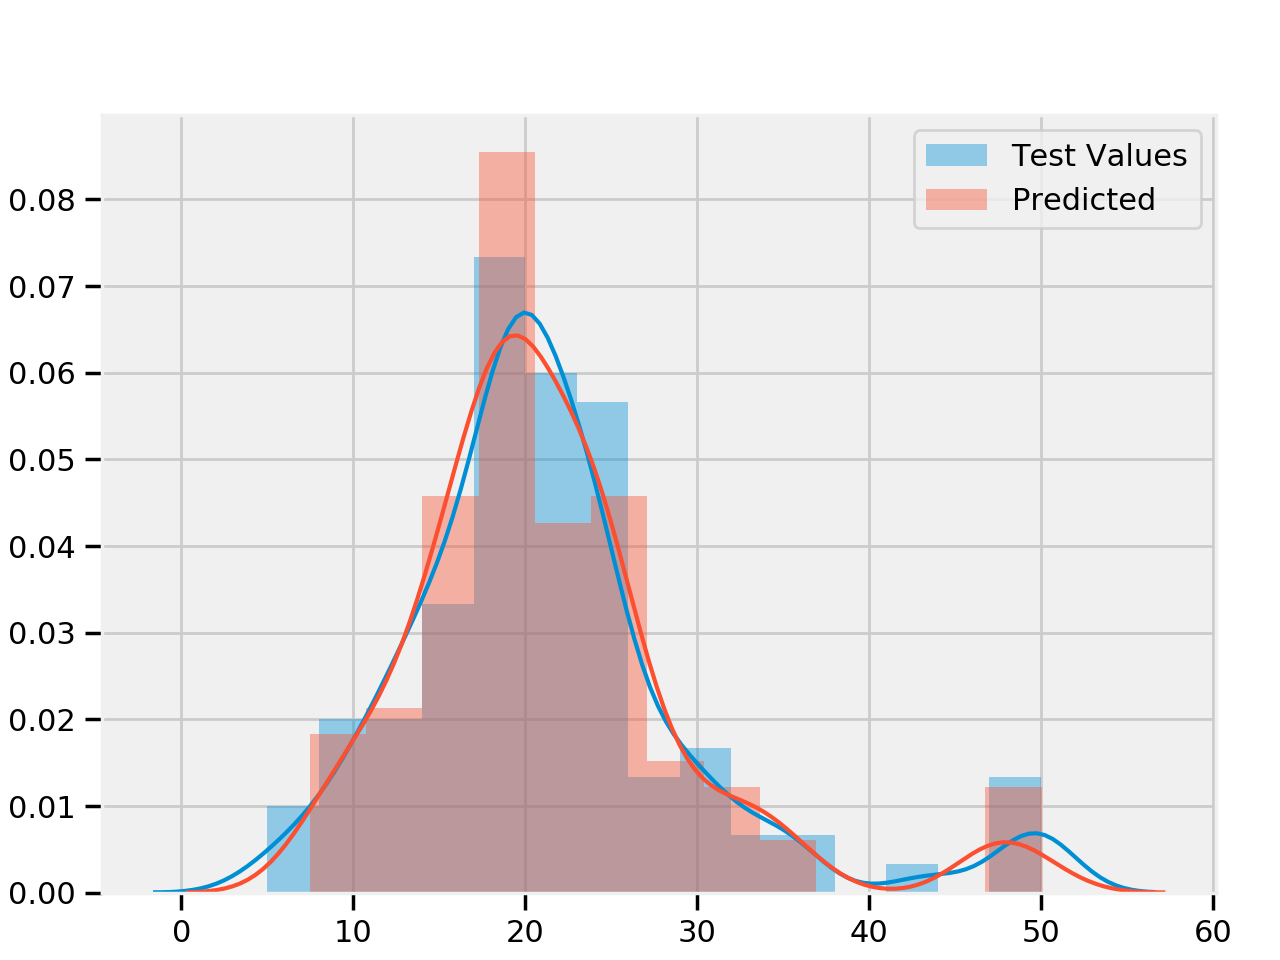

In [264]:
y_preds = model.predict(X_valid_scaled)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

<IPython.core.display.Javascript object>


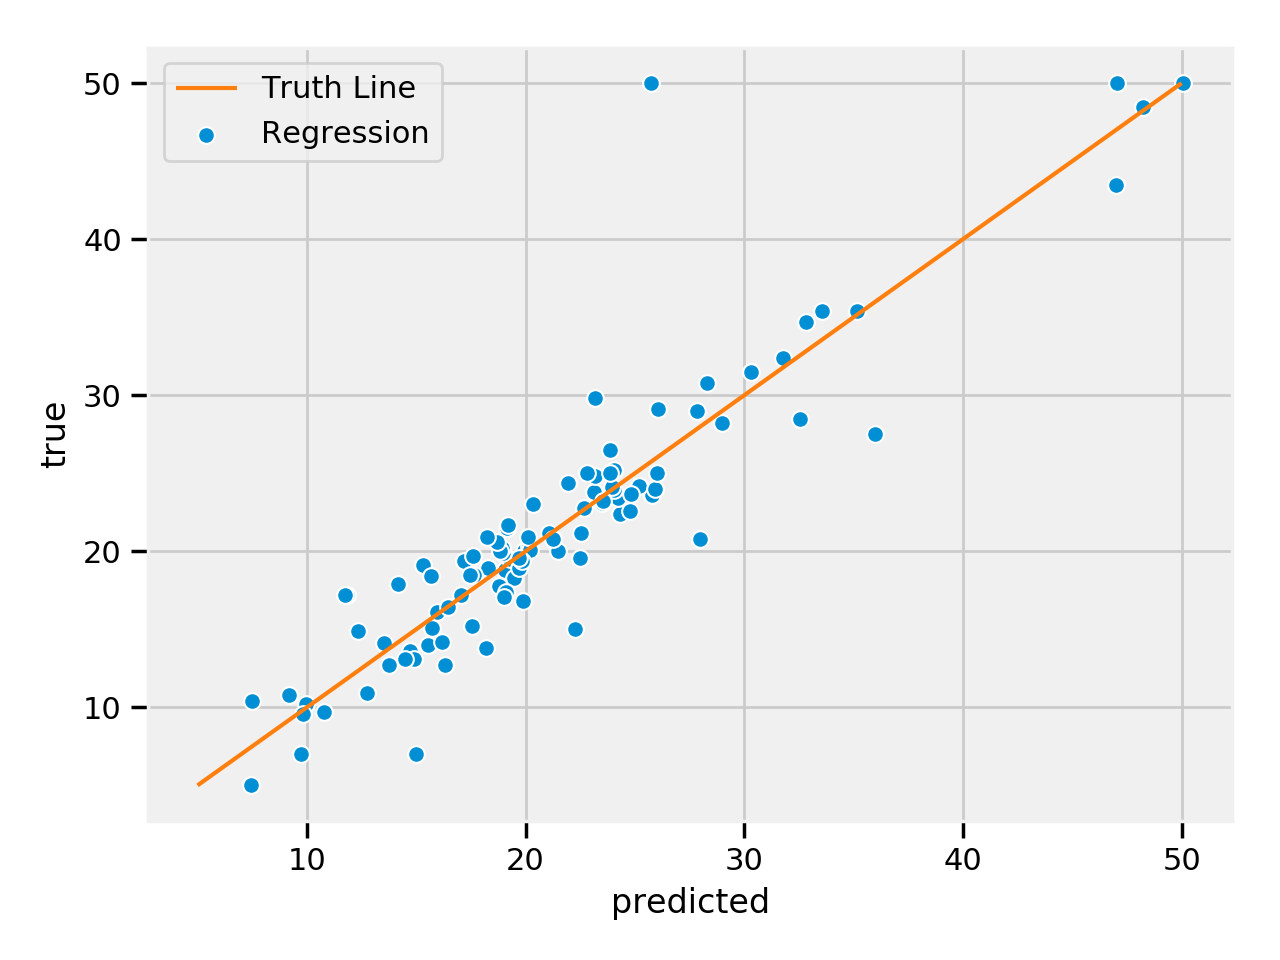

In [265]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

I'm very happy with that model...let's try a neural net

Below we define the function to create the baseline model to be evaluated.

It is a simple model that has a single fully connected hidden layer with the same number of neurons as input attributes (13).

The network uses good practices such as the rectifier activation function for the hidden layer.

**No activation function is used for the output layer because it is a regression problem and we are interested in predicting numerical values directly without transform.**

The efficient ADAM optimization algorithm is used and a mean squared error loss function is optimized. This will be the same metric that we will use to evaluate the performance of the model. It is a desirable metric because by taking the square root gives us an error value we can directly understand in the context of the problem (thousands of dollars).

In [229]:
model = Sequential()
model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='linear'))

from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_pred)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 14        
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [230]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1)
history = model.fit(X_train_scaled.values, y_train, batch_size=10, epochs=1000,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[early_stop])

Train on 324 samples, validate on 82 samples
Epoch 1/1000
324/324 [==============================] - 0s - loss: 607.6184 - coeff_determination: 0.0013 - val_loss: 541.8088 - val_coeff_determination: 0.0023
Epoch 2/1000
324/324 [==============================] - 0s - loss: 588.4631 - coeff_determination: 0.0050 - val_loss: 522.7470 - val_coeff_determination: 0.0059
Epoch 3/1000
324/324 [==============================] - 0s - loss: 563.8938 - coeff_determination: 0.0106 - val_loss: 498.7915 - val_coeff_determination: 0.0111
Epoch 4/1000
324/324 [==============================] - 0s - loss: 533.0989 - coeff_determination: 0.0186 - val_loss: 470.2456 - val_coeff_determination: 0.0182
Epoch 5/1000
324/324 [==============================] - 0s - loss: 496.3124 - coeff_determination: 0.0281 - val_loss: 434.4185 - val_coeff_determination: 0.0275
Epoch 6/1000
324/324 [==============================] - 0s - loss: 452.9513 - coeff_determination: 0.0406 - val_loss: 395.5129 - val_coeff_determinati

324/324 [==============================] - 0s - loss: 29.0497 - coeff_determination: 0.6243 - val_loss: 38.3346 - val_coeff_determination: 0.2552
Epoch 52/1000
324/324 [==============================] - 0s - loss: 28.6621 - coeff_determination: 0.5430 - val_loss: 38.1202 - val_coeff_determination: 0.2554
Epoch 53/1000
324/324 [==============================] - 0s - loss: 28.2829 - coeff_determination: 0.5725 - val_loss: 37.6429 - val_coeff_determination: 0.2620
Epoch 54/1000
324/324 [==============================] - 0s - loss: 27.8990 - coeff_determination: 0.6397 - val_loss: 37.3068 - val_coeff_determination: 0.2649
Epoch 55/1000
324/324 [==============================] - 0s - loss: 27.5525 - coeff_determination: 0.5886 - val_loss: 36.8806 - val_coeff_determination: 0.2689
Epoch 56/1000
324/324 [==============================] - 0s - loss: 27.2491 - coeff_determination: 0.6377 - val_loss: 36.4049 - val_coeff_determination: 0.2772
Epoch 57/1000
324/324 [==============================]

324/324 [==============================] - 0s - loss: 18.0263 - coeff_determination: 0.7091 - val_loss: 23.5036 - val_coeff_determination: 0.4865
Epoch 102/1000
324/324 [==============================] - 0s - loss: 17.8720 - coeff_determination: 0.7659 - val_loss: 23.1178 - val_coeff_determination: 0.4950
Epoch 103/1000
324/324 [==============================] - 0s - loss: 17.7720 - coeff_determination: 0.6909 - val_loss: 22.9733 - val_coeff_determination: 0.4972
Epoch 104/1000
324/324 [==============================] - 0s - loss: 17.6493 - coeff_determination: 0.7653 - val_loss: 22.7626 - val_coeff_determination: 0.5026
Epoch 105/1000
324/324 [==============================] - 0s - loss: 17.4964 - coeff_determination: 0.7377 - val_loss: 22.6317 - val_coeff_determination: 0.5046
Epoch 106/1000
324/324 [==============================] - 0s - loss: 17.3446 - coeff_determination: 0.7314 - val_loss: 22.3805 - val_coeff_determination: 0.5090
Epoch 107/1000
324/324 [=========================

324/324 [==============================] - 0s - loss: 13.0489 - coeff_determination: 0.7163 - val_loss: 16.3014 - val_coeff_determination: 0.6470
Epoch 152/1000
324/324 [==============================] - 0s - loss: 12.9034 - coeff_determination: 0.8173 - val_loss: 16.0949 - val_coeff_determination: 0.6521
Epoch 153/1000
324/324 [==============================] - 0s - loss: 12.9205 - coeff_determination: 0.7611 - val_loss: 16.0779 - val_coeff_determination: 0.6523
Epoch 154/1000
324/324 [==============================] - 0s - loss: 12.7947 - coeff_determination: 0.8202 - val_loss: 16.2554 - val_coeff_determination: 0.6506
Epoch 155/1000
324/324 [==============================] - 0s - loss: 12.7612 - coeff_determination: 0.7848 - val_loss: 16.0958 - val_coeff_determination: 0.6531
Epoch 156/1000
324/324 [==============================] - 0s - loss: 12.6983 - coeff_determination: 0.8212 - val_loss: 16.0710 - val_coeff_determination: 0.6527
Epoch 157/1000
324/324 [=========================

324/324 [==============================] - 0s - loss: 10.9805 - coeff_determination: 0.8329 - val_loss: 13.9130 - val_coeff_determination: 0.7049
Epoch 202/1000
324/324 [==============================] - 0s - loss: 10.9799 - coeff_determination: 0.7641 - val_loss: 13.8845 - val_coeff_determination: 0.7058
Epoch 203/1000
324/324 [==============================] - 0s - loss: 10.9962 - coeff_determination: 0.8316 - val_loss: 14.0309 - val_coeff_determination: 0.7033
Epoch 204/1000
324/324 [==============================] - 0s - loss: 10.9257 - coeff_determination: 0.8380 - val_loss: 13.7482 - val_coeff_determination: 0.7077
Epoch 205/1000
324/324 [==============================] - 0s - loss: 10.9523 - coeff_determination: 0.8512 - val_loss: 13.8212 - val_coeff_determination: 0.7087
Epoch 206/1000
324/324 [==============================] - 0s - loss: 10.9007 - coeff_determination: 0.8376 - val_loss: 13.7302 - val_coeff_determination: 0.7103
Epoch 207/1000
324/324 [=========================

324/324 [==============================] - 0s - loss: 9.8851 - coeff_determination: 0.8726 - val_loss: 12.7395 - val_coeff_determination: 0.7344
Epoch 253/1000
324/324 [==============================] - 0s - loss: 9.9001 - coeff_determination: 0.8339 - val_loss: 12.6439 - val_coeff_determination: 0.7372
Epoch 254/1000
324/324 [==============================] - 0s - loss: 9.8414 - coeff_determination: 0.8370 - val_loss: 12.6717 - val_coeff_determination: 0.7363
Epoch 255/1000
324/324 [==============================] - 0s - loss: 9.8691 - coeff_determination: 0.8518 - val_loss: 12.6540 - val_coeff_determination: 0.7367
Epoch 256/1000
324/324 [==============================] - 0s - loss: 9.8380 - coeff_determination: 0.8471 - val_loss: 12.6681 - val_coeff_determination: 0.7373
Epoch 257/1000
324/324 [==============================] - 0s - loss: 9.8073 - coeff_determination: 0.7938 - val_loss: 12.9451 - val_coeff_determination: 0.7320
Epoch 258/1000
324/324 [==============================]

<IPython.core.display.Javascript object>


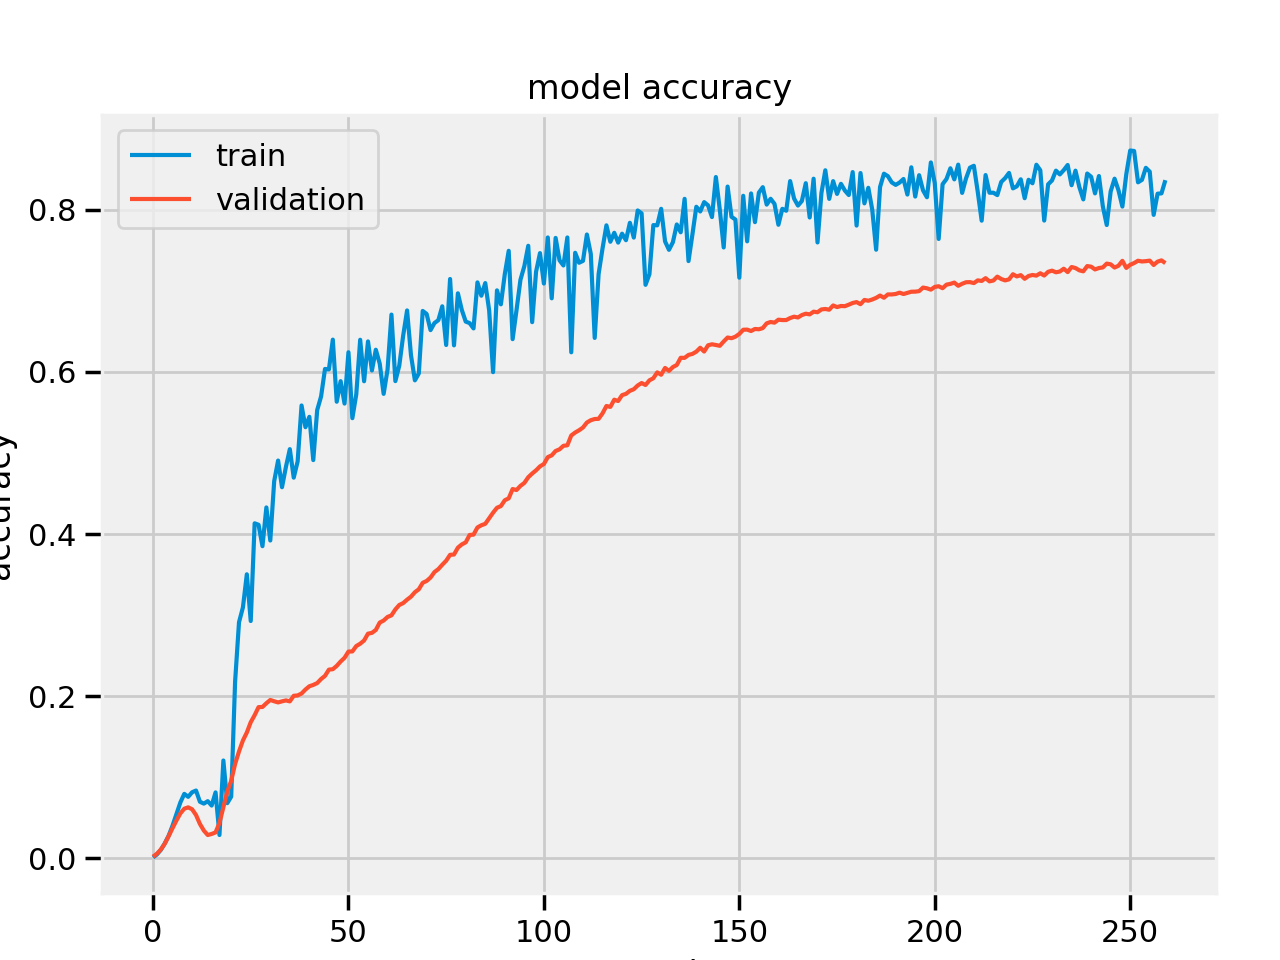

<IPython.core.display.Javascript object>


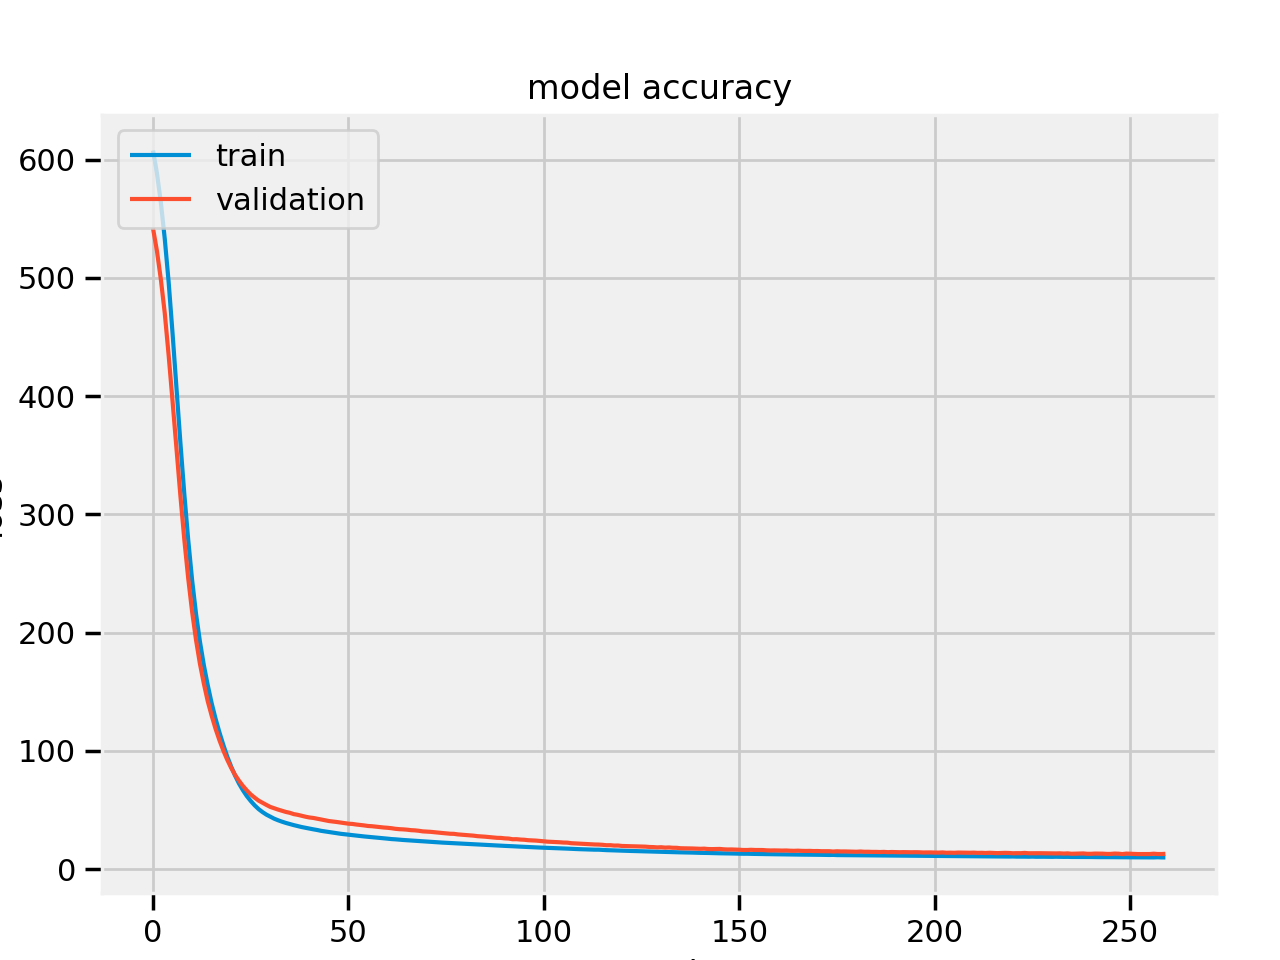

In [231]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['coeff_determination'])
ax.plot(history.history['val_coeff_determination'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

Note that the accuracy seems to be a silly measurement for this dataset...not sure why

 32/100 [========>.....................] - ETA: 0s['loss', 'coeff_determination']
[12.5271337890625, 0.87029636383056641]


<IPython.core.display.Javascript object>


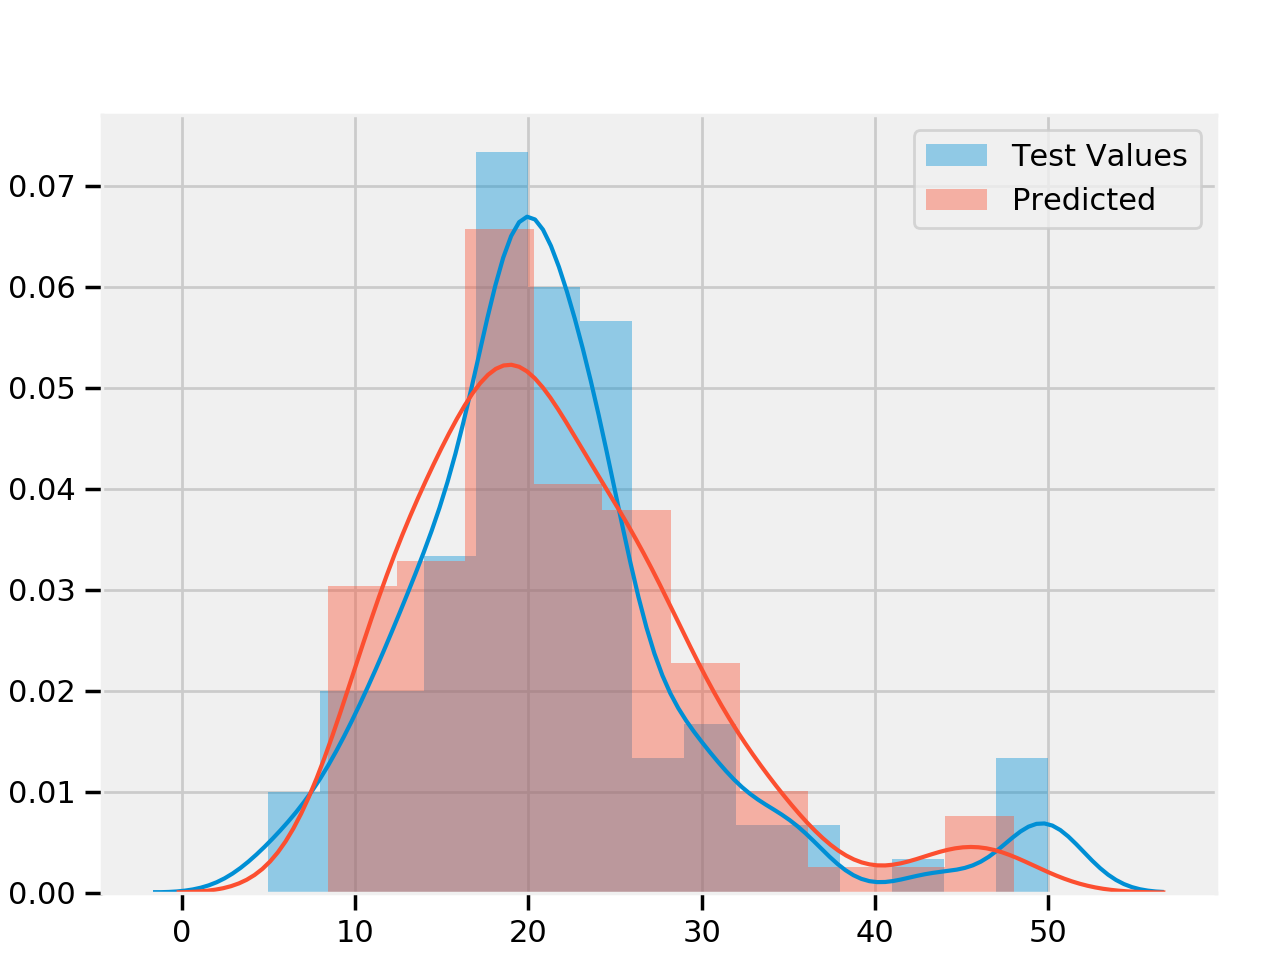

In [232]:
# evaluate(model, dataframe.columns[:13],
#          X_train_scaled, X_valid_scaled, y_train, y_valid)
score = model.evaluate(X_valid_scaled.values, y_valid)
print(model.metrics_names)
print(score)
y_preds = model.predict(X_valid_scaled.values)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

In [233]:
# quick and dirty comparison

def evaluate_ann(model, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train.values)
    valid_pred = model.predict(X_valid.values)
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [234]:
evaluate_ann(model, X_train_scaled, X_valid_scaled, y_train, y_valid)

Training:   rmse = 3.21 	 mape = 50.72
Validation: rmse = 3.54 	 mape = 48.18


<IPython.core.display.Javascript object>


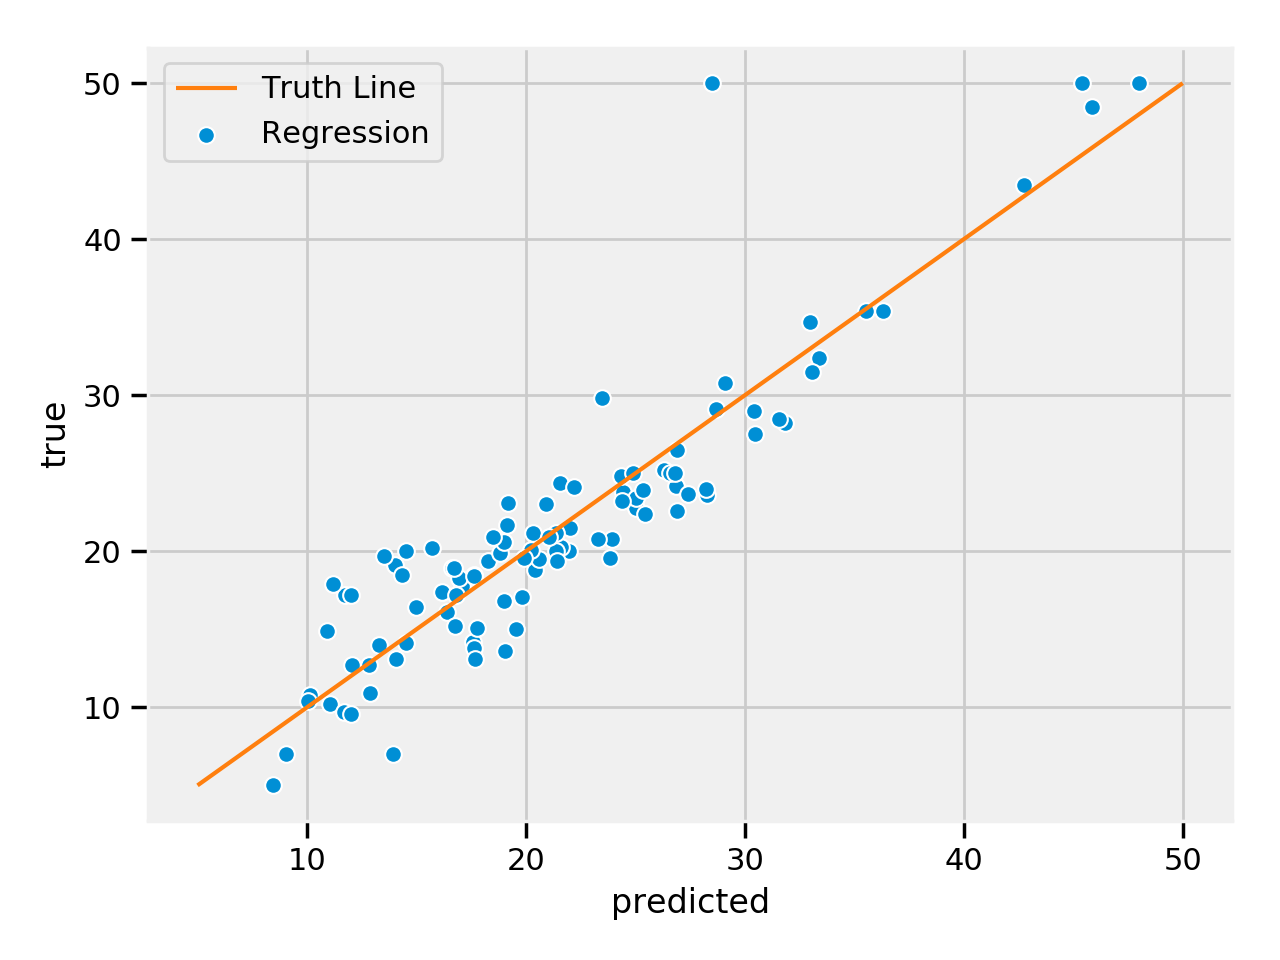

In [242]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

Very nice performance with the simple model!

Much more complicated model

In [243]:
from keras.layers import Dropout
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_pred)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

model = Sequential()
model.add(Dense(20, input_dim=13, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1)
history = model.fit(X_train_scaled.values, y_train, batch_size=10, epochs=1000,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 20)                280       
_________________________________________________________________
dropout_31 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 8)                 168       
_________________________________________________________________
dropout_32 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 9         
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________
Train on 324 samples, validate on 82 samples
Epoch 1/1000
324/324 [==============================] - 0s - loss: 592.0359 - coeff_determination: 

324/324 [==============================] - 0s - loss: 30.2103 - coeff_determination: 0.5549 - val_loss: 20.1355 - val_coeff_determination: 0.6022
Epoch 46/1000
324/324 [==============================] - 0s - loss: 32.1877 - coeff_determination: 0.4847 - val_loss: 19.9663 - val_coeff_determination: 0.5965
Epoch 47/1000
324/324 [==============================] - 0s - loss: 33.2794 - coeff_determination: 0.4110 - val_loss: 19.6593 - val_coeff_determination: 0.6021
Epoch 48/1000
324/324 [==============================] - 0s - loss: 38.3165 - coeff_determination: 0.4791 - val_loss: 19.5686 - val_coeff_determination: 0.6039
Epoch 49/1000
324/324 [==============================] - 0s - loss: 36.2632 - coeff_determination: 0.4143 - val_loss: 18.9422 - val_coeff_determination: 0.6208
Epoch 50/1000
324/324 [==============================] - 0s - loss: 30.5570 - coeff_determination: 0.5655 - val_loss: 18.3506 - val_coeff_determination: 0.6335
Epoch 51/1000
324/324 [==============================]

dict_keys(['val_loss', 'val_coeff_determination', 'loss', 'coeff_determination'])


<IPython.core.display.Javascript object>


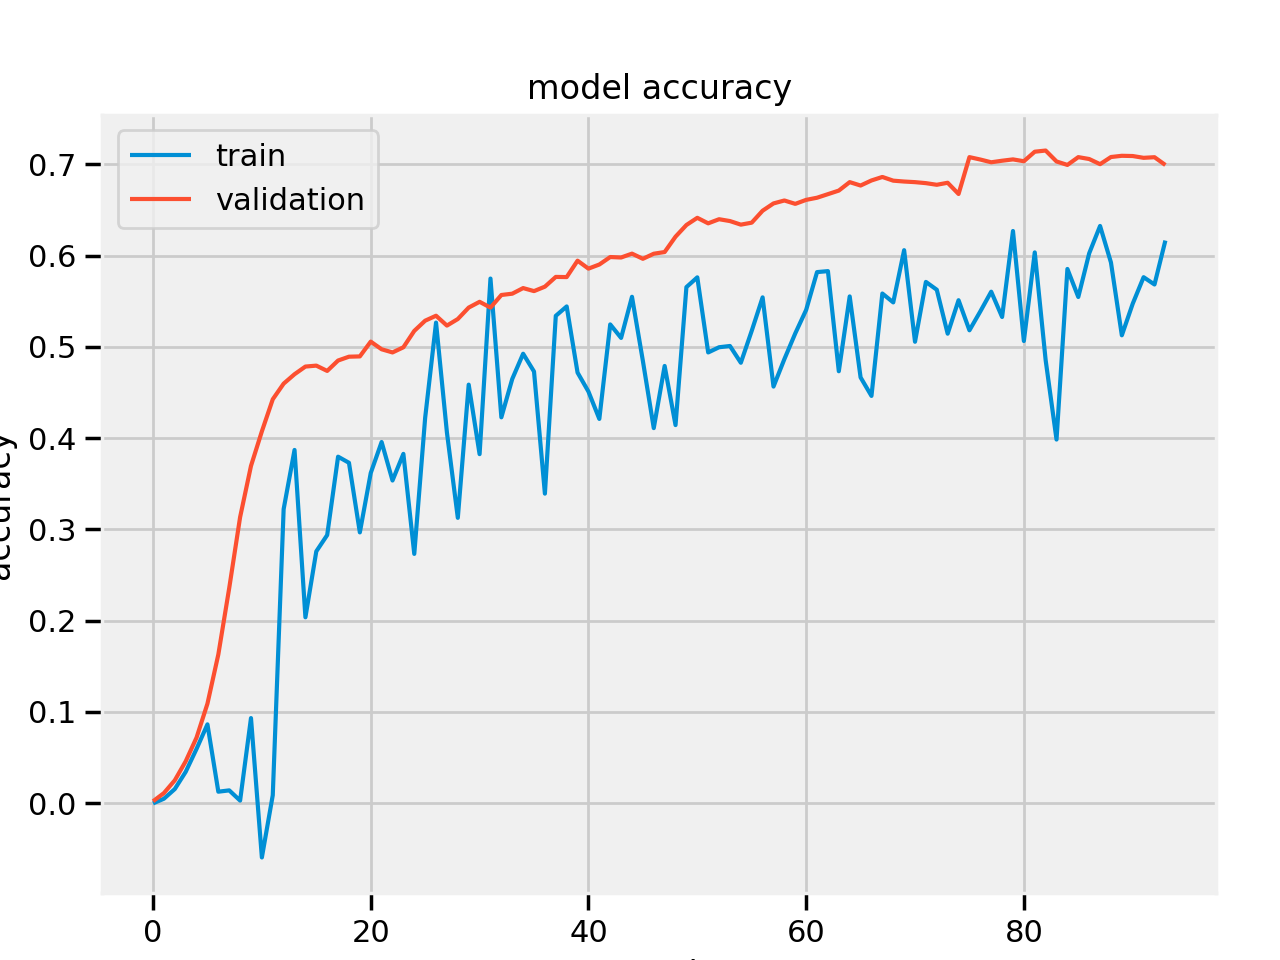

<IPython.core.display.Javascript object>


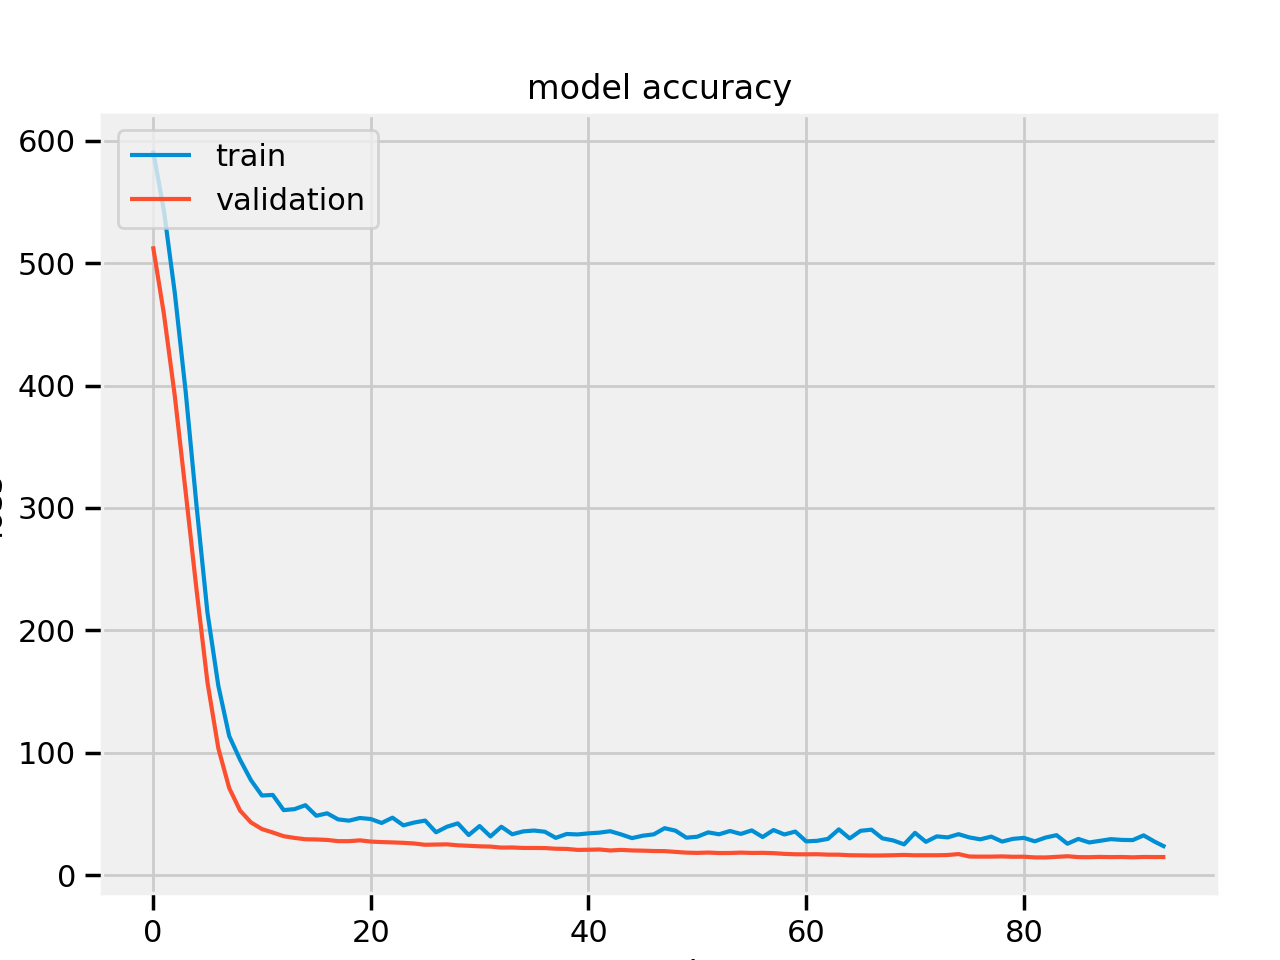

 32/100 [========>.....................] - ETA: 0s['loss', 'coeff_determination']
[15.615303955078126, 0.84881564855575564]


<IPython.core.display.Javascript object>


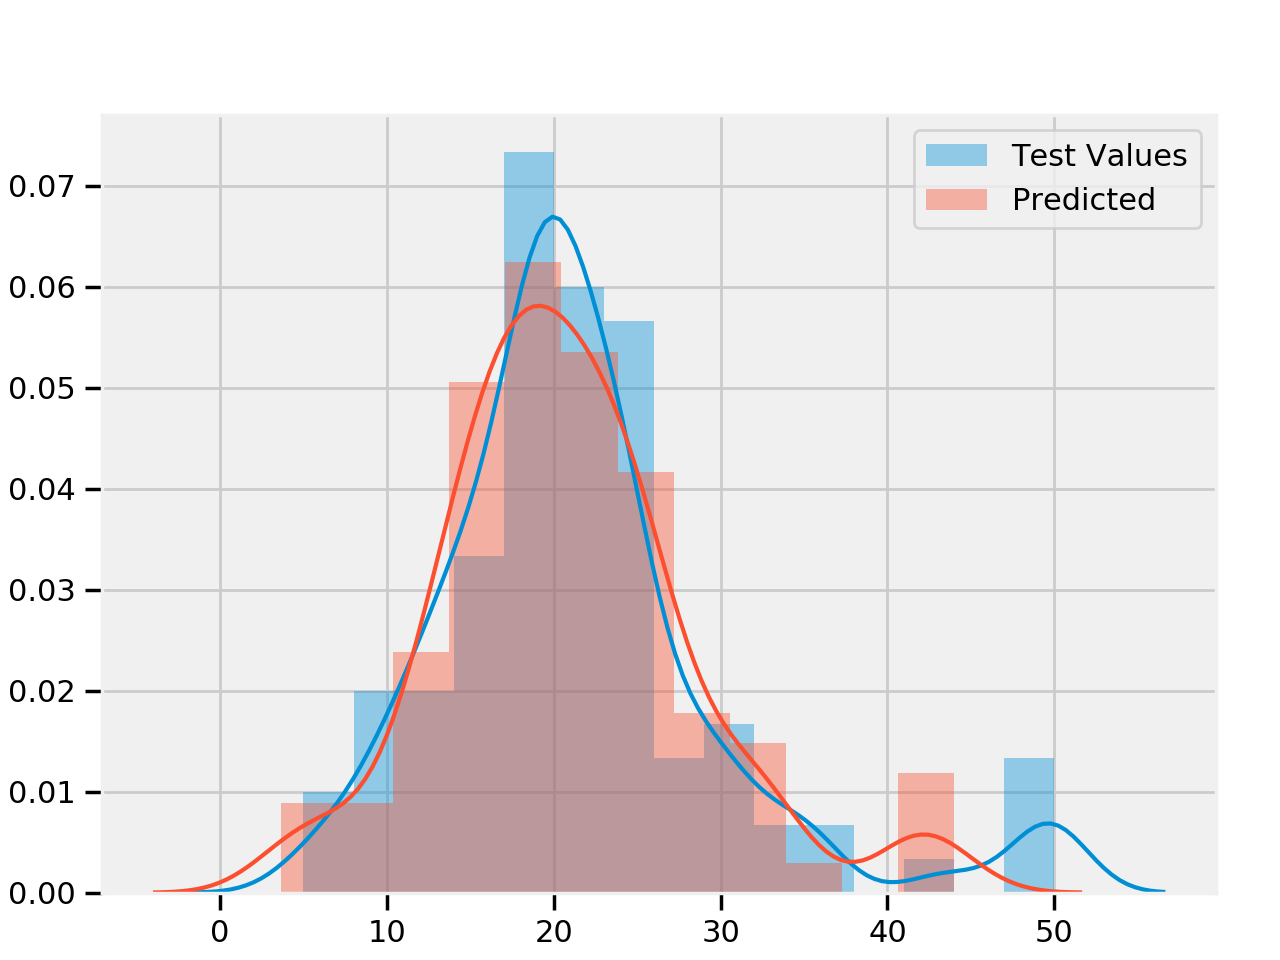

In [244]:
print(history.history.keys())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['coeff_determination'])
ax.plot(history.history['val_coeff_determination'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_valid_scaled.values, y_valid)
print(model.metrics_names)
print(score)
y_preds = model.predict(X_valid_scaled.values)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

Training:   rmse = 3.43 	 mape = 48.23
Validation: rmse = 3.95 	 mape = 46.31


<IPython.core.display.Javascript object>


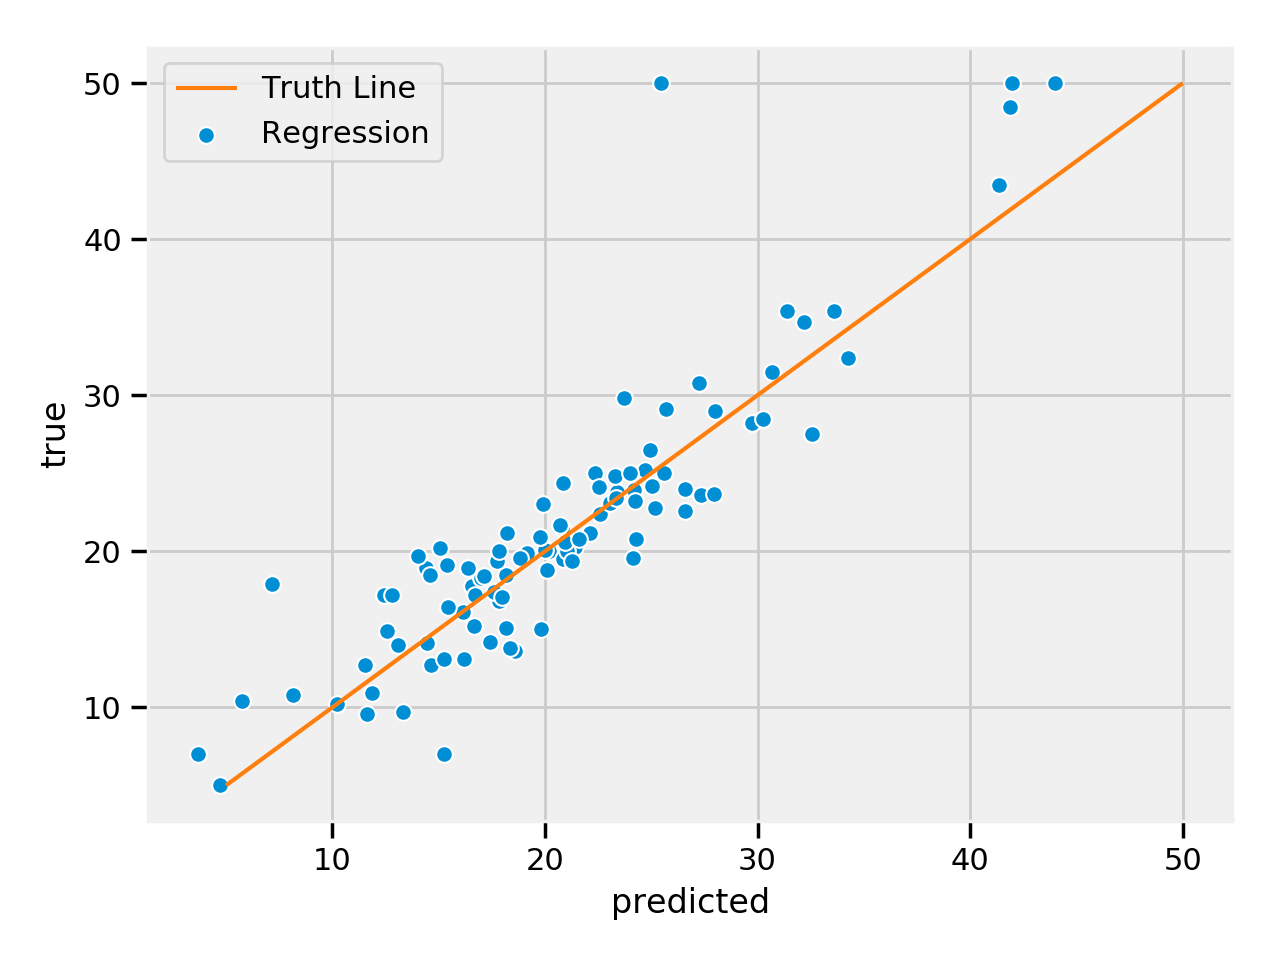

In [245]:
evaluate_ann(model, X_train_scaled, X_valid_scaled, y_train, y_valid)

y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 13)                182       
_________________________________________________________________
dropout_33 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 8)                 112       
_________________________________________________________________
dropout_34 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_76 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_77 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 5         
Total para

324/324 [==============================] - 0s - loss: 26.5981 - acc: 0.0154 - val_loss: 18.3656 - val_acc: 0.0000e+00
Epoch 54/1000
324/324 [==============================] - 0s - loss: 29.0596 - acc: 0.0093 - val_loss: 17.0513 - val_acc: 0.0000e+00
Epoch 55/1000
324/324 [==============================] - 0s - loss: 28.8433 - acc: 0.0031 - val_loss: 16.9678 - val_acc: 0.0000e+00
Epoch 56/1000
324/324 [==============================] - 0s - loss: 31.5488 - acc: 0.0062 - val_loss: 17.2768 - val_acc: 0.0000e+00
Epoch 57/1000
324/324 [==============================] - 0s - loss: 32.6141 - acc: 0.0062 - val_loss: 17.6629 - val_acc: 0.0000e+00
Epoch 58/1000
324/324 [==============================] - 0s - loss: 28.2487 - acc: 0.0154 - val_loss: 16.4429 - val_acc: 0.0000e+00
Epoch 59/1000
324/324 [==============================] - 0s - loss: 30.2804 - acc: 0.0062 - val_loss: 16.9165 - val_acc: 0.0122
Epoch 60/1000
324/324 [==============================] - 0s - loss: 27.0021 - acc: 0.0123 - va

324/324 [==============================] - 0s - loss: 19.4959 - acc: 0.0123 - val_loss: 12.6647 - val_acc: 0.0000e+00
Epoch 116/1000
324/324 [==============================] - 0s - loss: 16.0546 - acc: 0.0123 - val_loss: 12.5254 - val_acc: 0.0122
Epoch 117/1000
324/324 [==============================] - 0s - loss: 18.1999 - acc: 0.0154 - val_loss: 12.9342 - val_acc: 0.0122
Epoch 118/1000
324/324 [==============================] - 0s - loss: 20.2031 - acc: 0.0062 - val_loss: 12.5499 - val_acc: 0.0122
Epoch 119/1000
324/324 [==============================] - 0s - loss: 17.1130 - acc: 0.0093 - val_loss: 13.0623 - val_acc: 0.0122
Epoch 120/1000
324/324 [==============================] - 0s - loss: 14.2140 - acc: 0.0185 - val_loss: 13.0136 - val_acc: 0.0122
Epoch 00119: early stopping


<IPython.core.display.Javascript object>


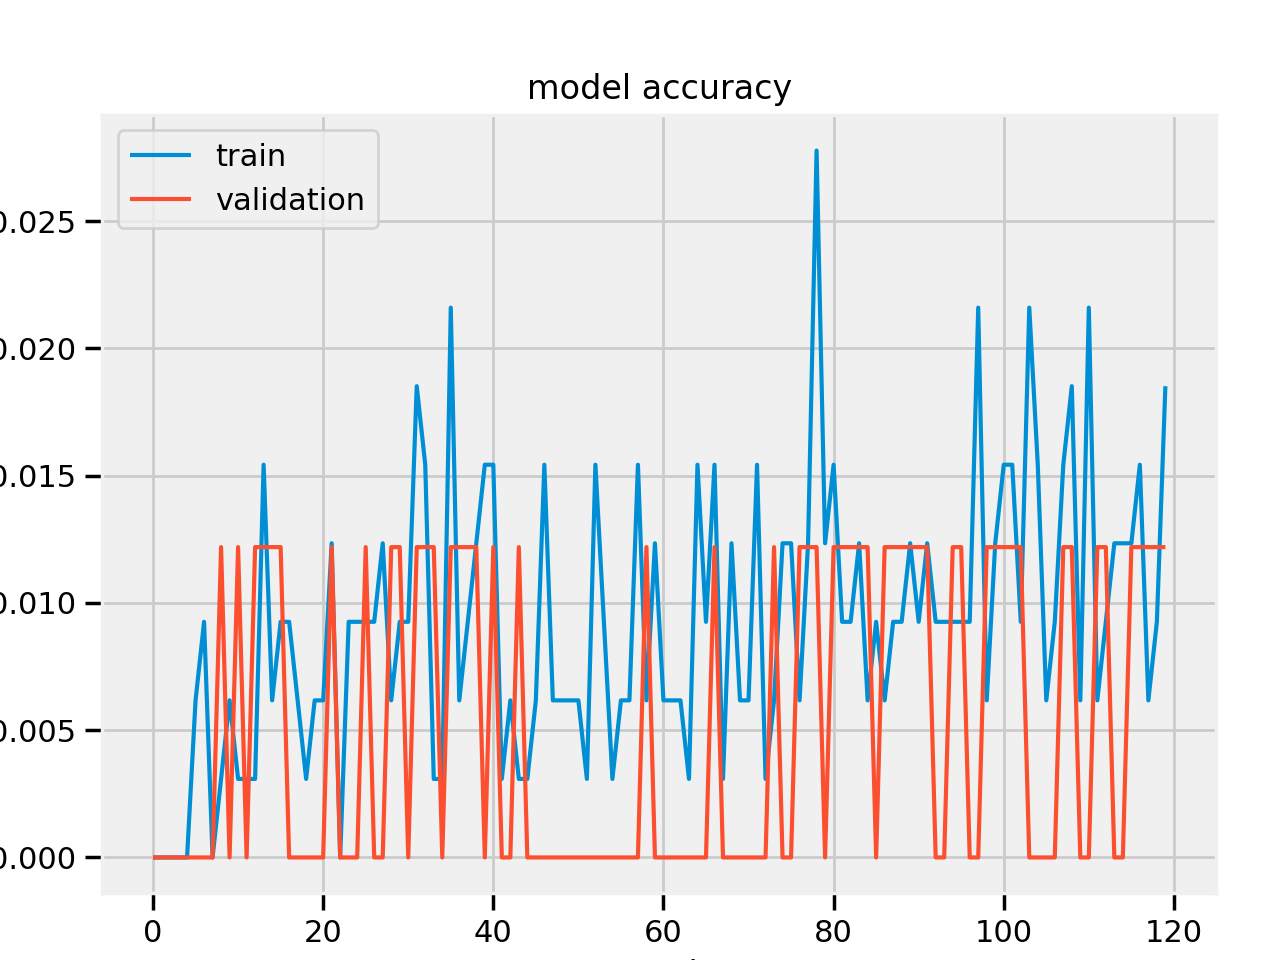

<IPython.core.display.Javascript object>


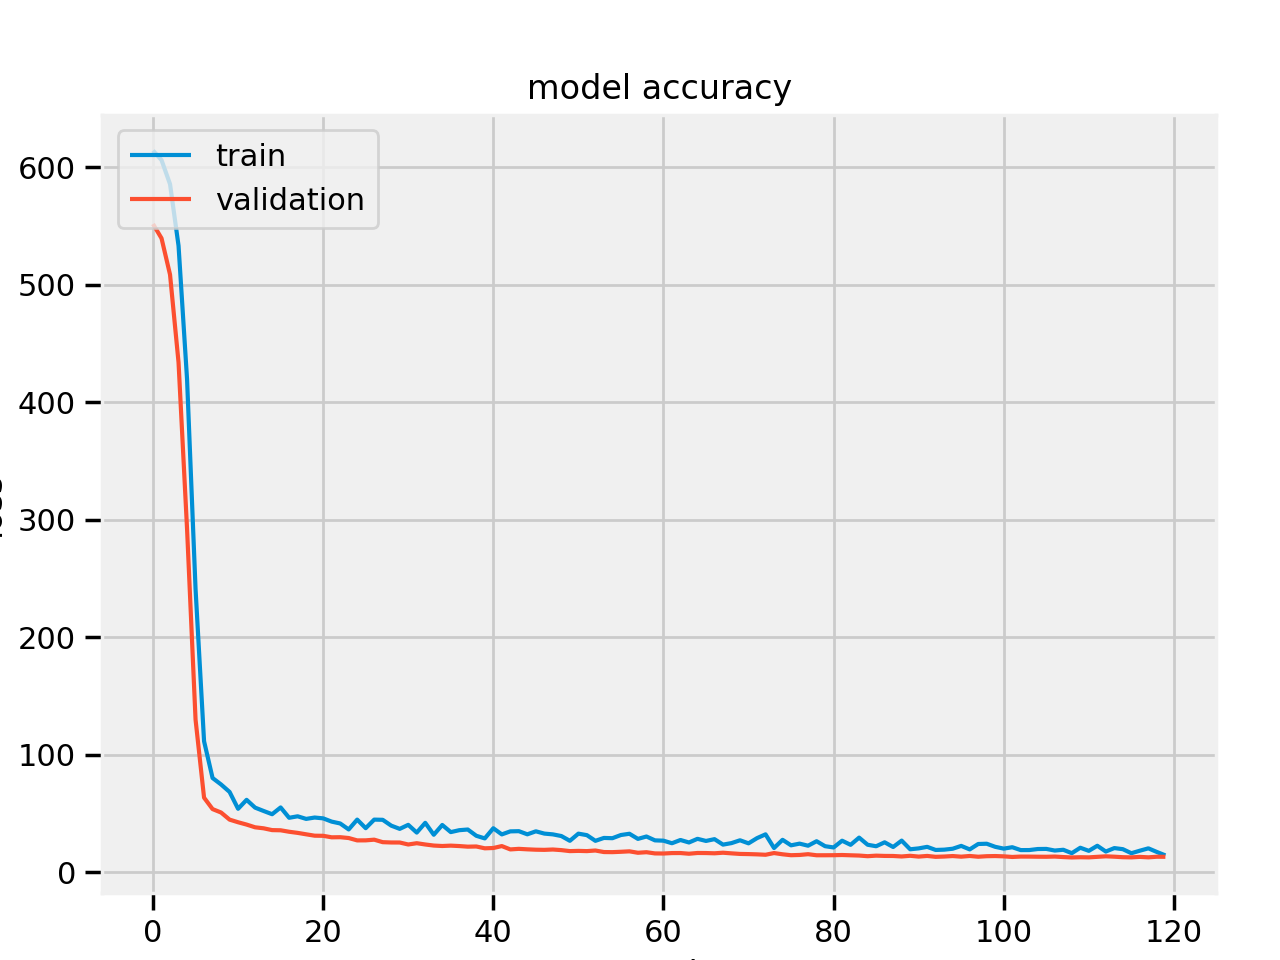

 32/100 [========>.....................] - ETA: 0s['loss', 'acc']
[14.514769897460937, 0.02]


<IPython.core.display.Javascript object>


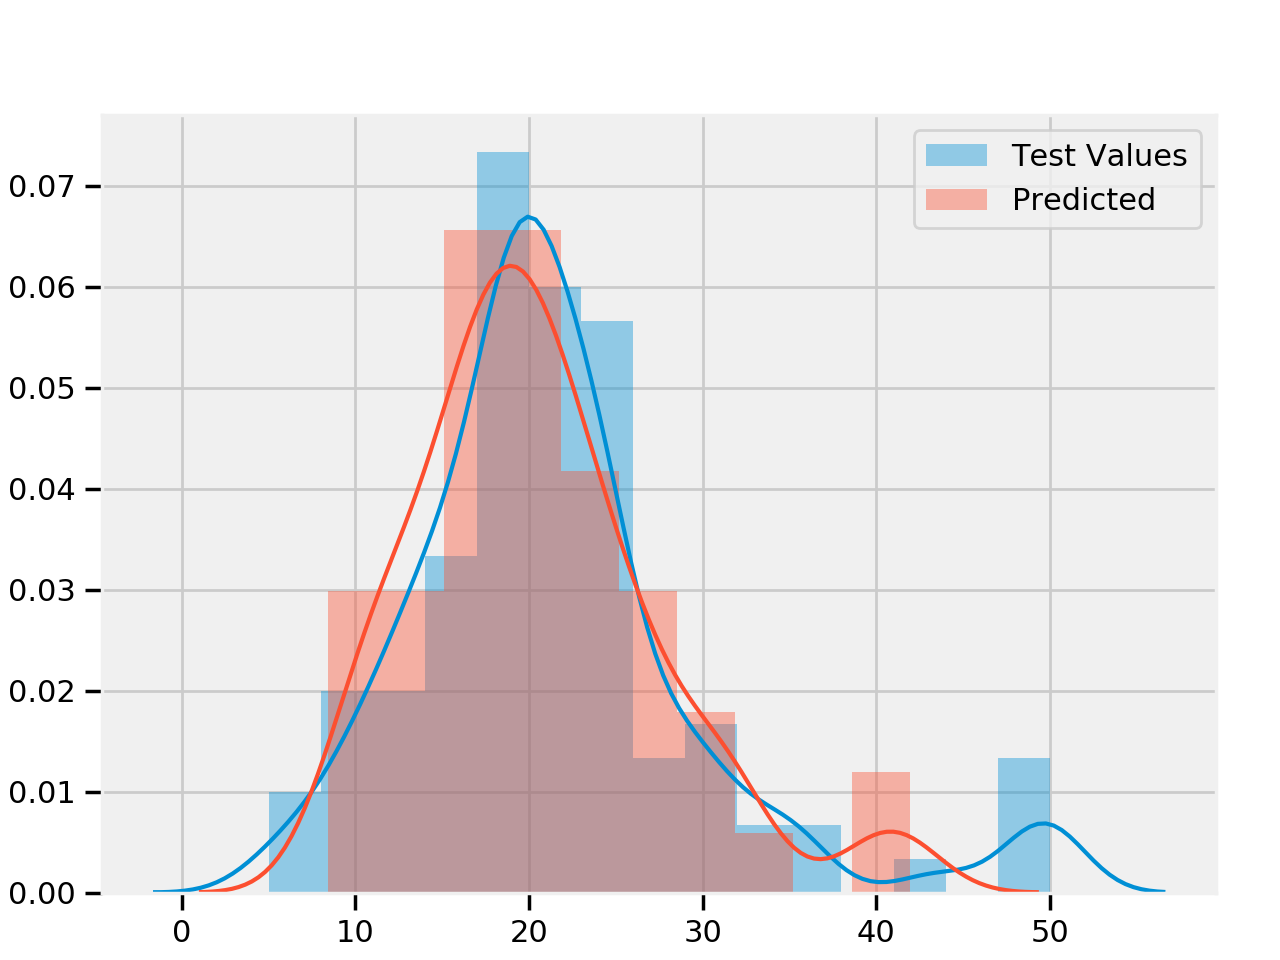

In [246]:
from keras.layers import Dropout
model = Sequential()
model.add(Dense(13, input_dim=13, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='relu'))
model.add(Dense(4, activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1)
history = model.fit(X_train_scaled.values, y_train, batch_size=10, epochs=1000,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[early_stop])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['coeff_determination'])
ax.plot(history.history['val_coeff_determination'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_valid_scaled.values, y_valid)
print(model.metrics_names)
print(score)
y_preds = model.predict(X_valid_scaled.values)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

<IPython.core.display.Javascript object>


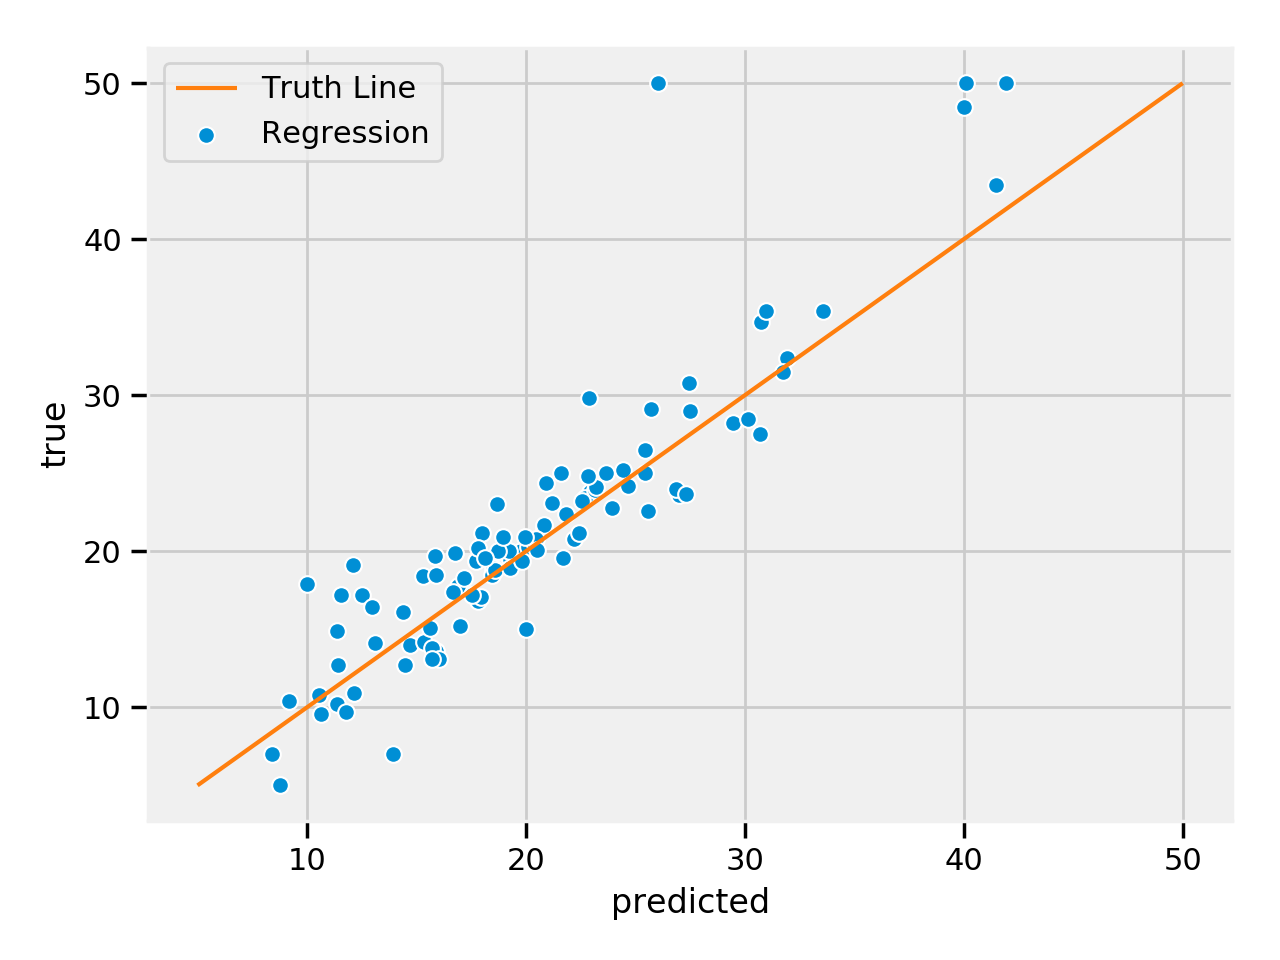

In [247]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 13)                182       
_________________________________________________________________
dropout_35 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 8)                 112       
_________________________________________________________________
dropout_36 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_81 (Dense)             (None, 6)                 54        
_________________________________________________________________
dropout_37 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_82 (Dense)             (None, 4)                 28        
__________

324/324 [==============================] - 0s - loss: 30.1913 - acc: 0.0123 - val_loss: 22.6348 - val_acc: 0.0000e+00
Epoch 53/1000
324/324 [==============================] - 0s - loss: 32.8775 - acc: 0.0154 - val_loss: 20.2179 - val_acc: 0.0000e+00
Epoch 54/1000
324/324 [==============================] - 0s - loss: 30.1218 - acc: 0.0062 - val_loss: 22.2752 - val_acc: 0.0122
Epoch 55/1000
324/324 [==============================] - 0s - loss: 37.2756 - acc: 0.0062 - val_loss: 21.0434 - val_acc: 0.0122
Epoch 56/1000
324/324 [==============================] - 0s - loss: 31.2152 - acc: 0.0123 - val_loss: 21.6739 - val_acc: 0.0122
Epoch 57/1000
324/324 [==============================] - 0s - loss: 30.6513 - acc: 0.0154 - val_loss: 21.1674 - val_acc: 0.0122
Epoch 58/1000
324/324 [==============================] - 0s - loss: 35.2091 - acc: 0.0123 - val_loss: 21.5129 - val_acc: 0.0122
Epoch 59/1000
324/324 [==============================] - 0s - loss: 30.9718 - acc: 0.0093 - val_loss: 22.5433 

<IPython.core.display.Javascript object>


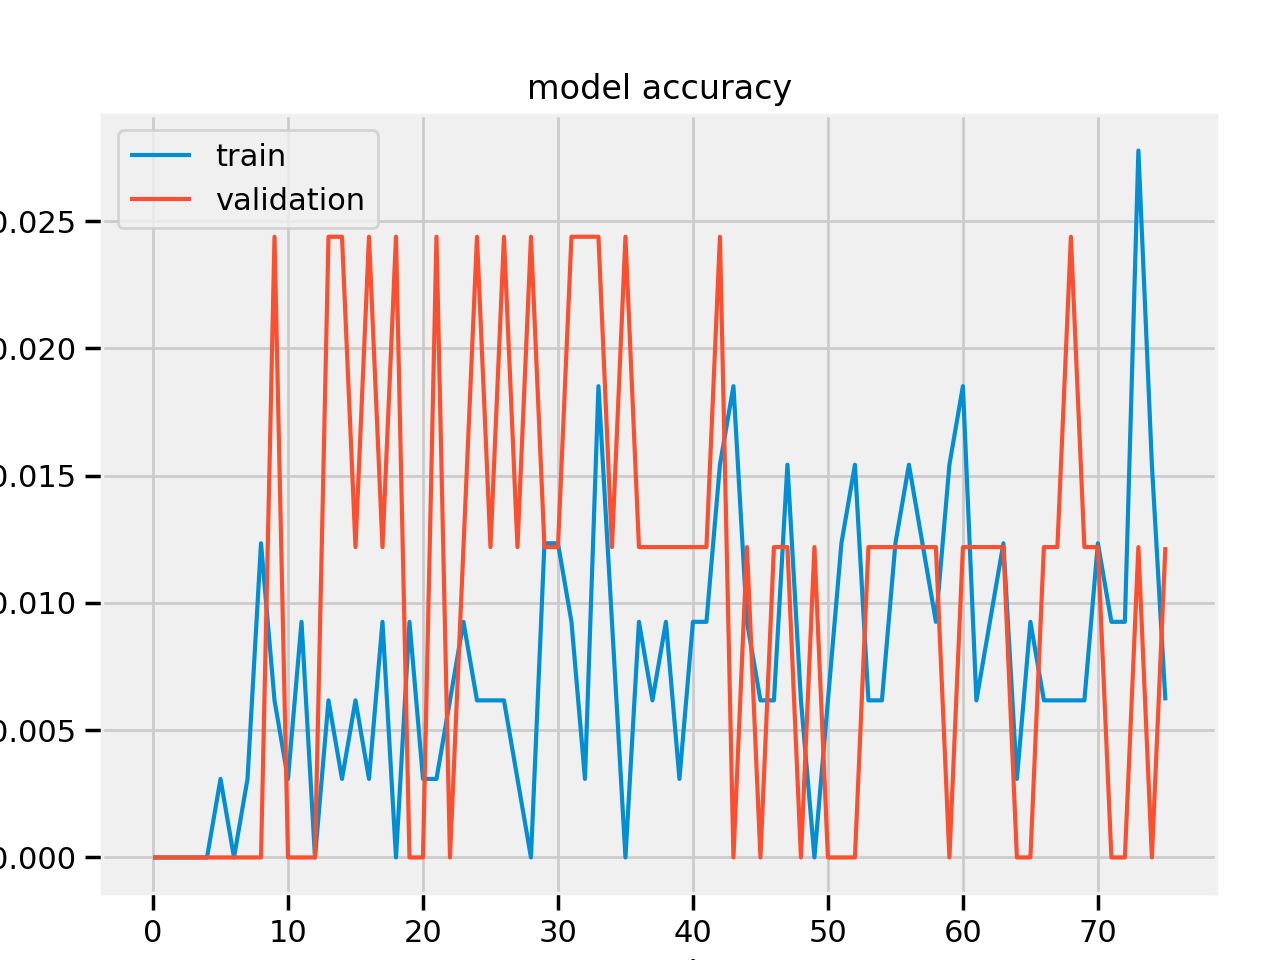

<IPython.core.display.Javascript object>


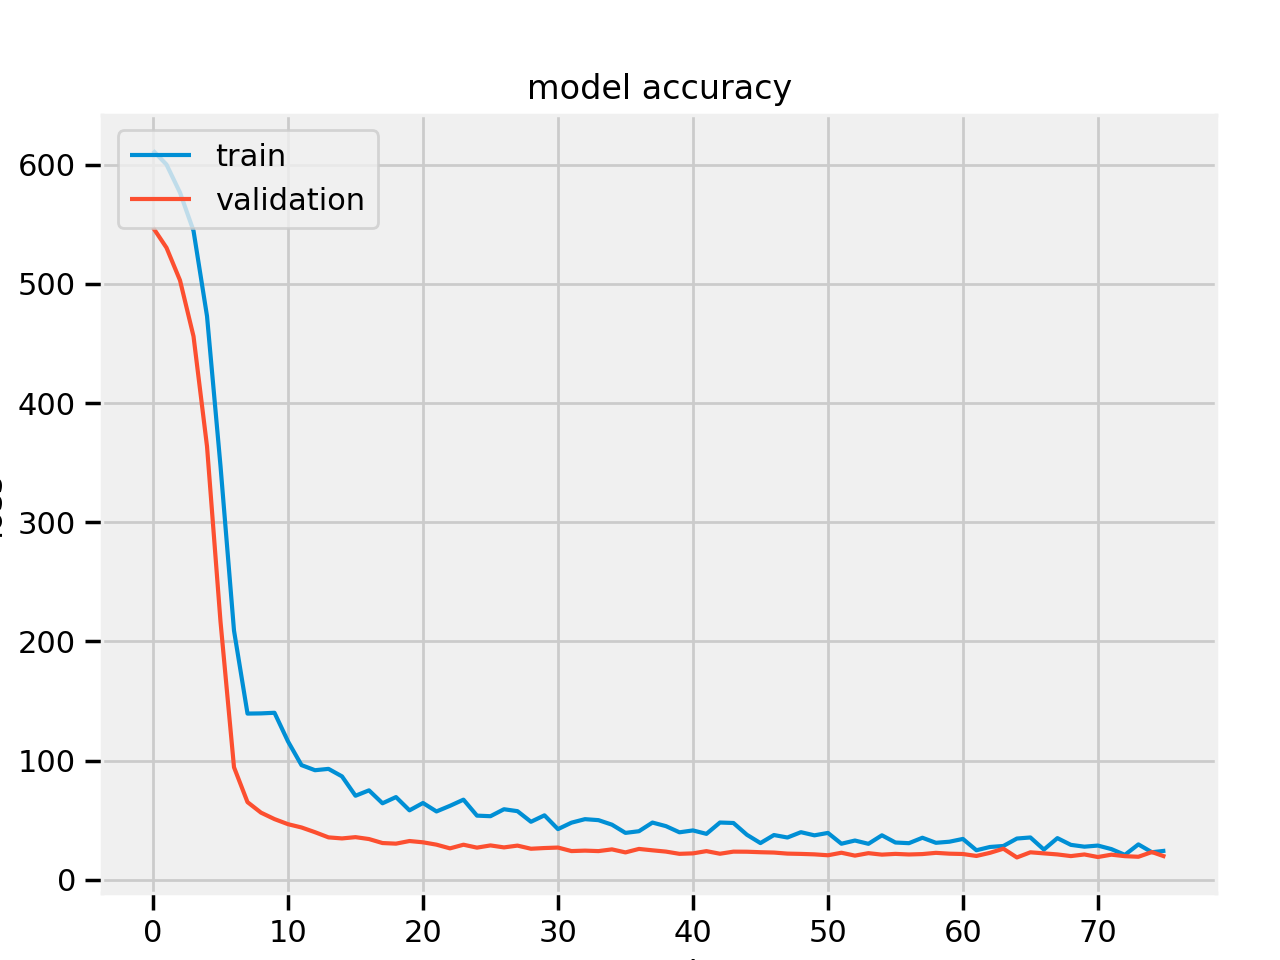

 32/100 [========>.....................] - ETA: 0s['loss', 'acc']
[20.815510864257813, 0.01]


<IPython.core.display.Javascript object>


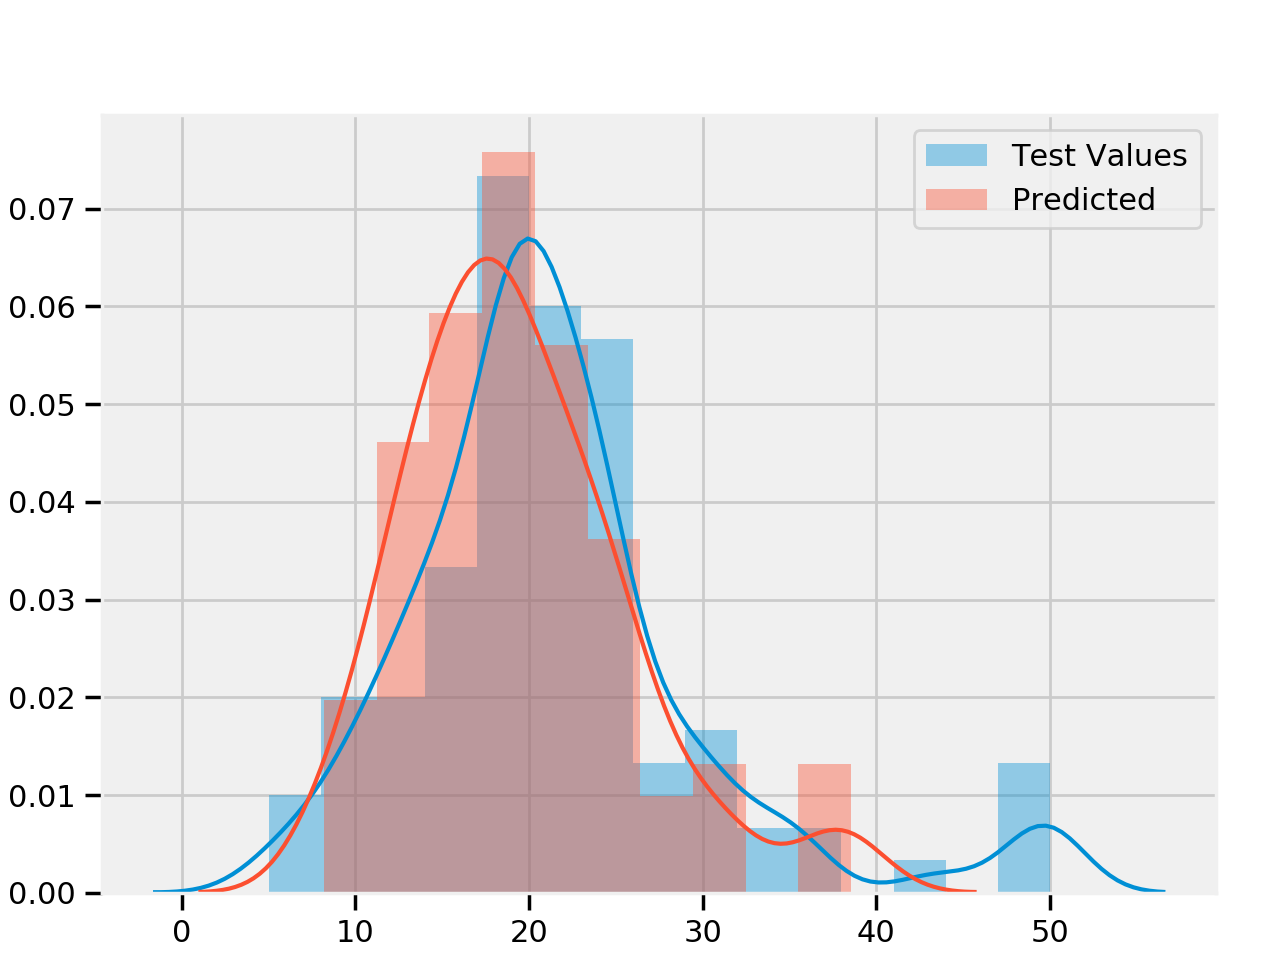

In [248]:
from keras.layers import Dropout
model = Sequential()
model.add(Dense(13, input_dim=13, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1)
history = model.fit(X_train_scaled.values, y_train, batch_size=10, epochs=1000,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[early_stop])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['coeff_determination'])
ax.plot(history.history['val_coeff_determination'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_valid_scaled.values, y_valid)
print(model.metrics_names)
print(score)
y_preds = model.predict(X_valid_scaled.values)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

<IPython.core.display.Javascript object>


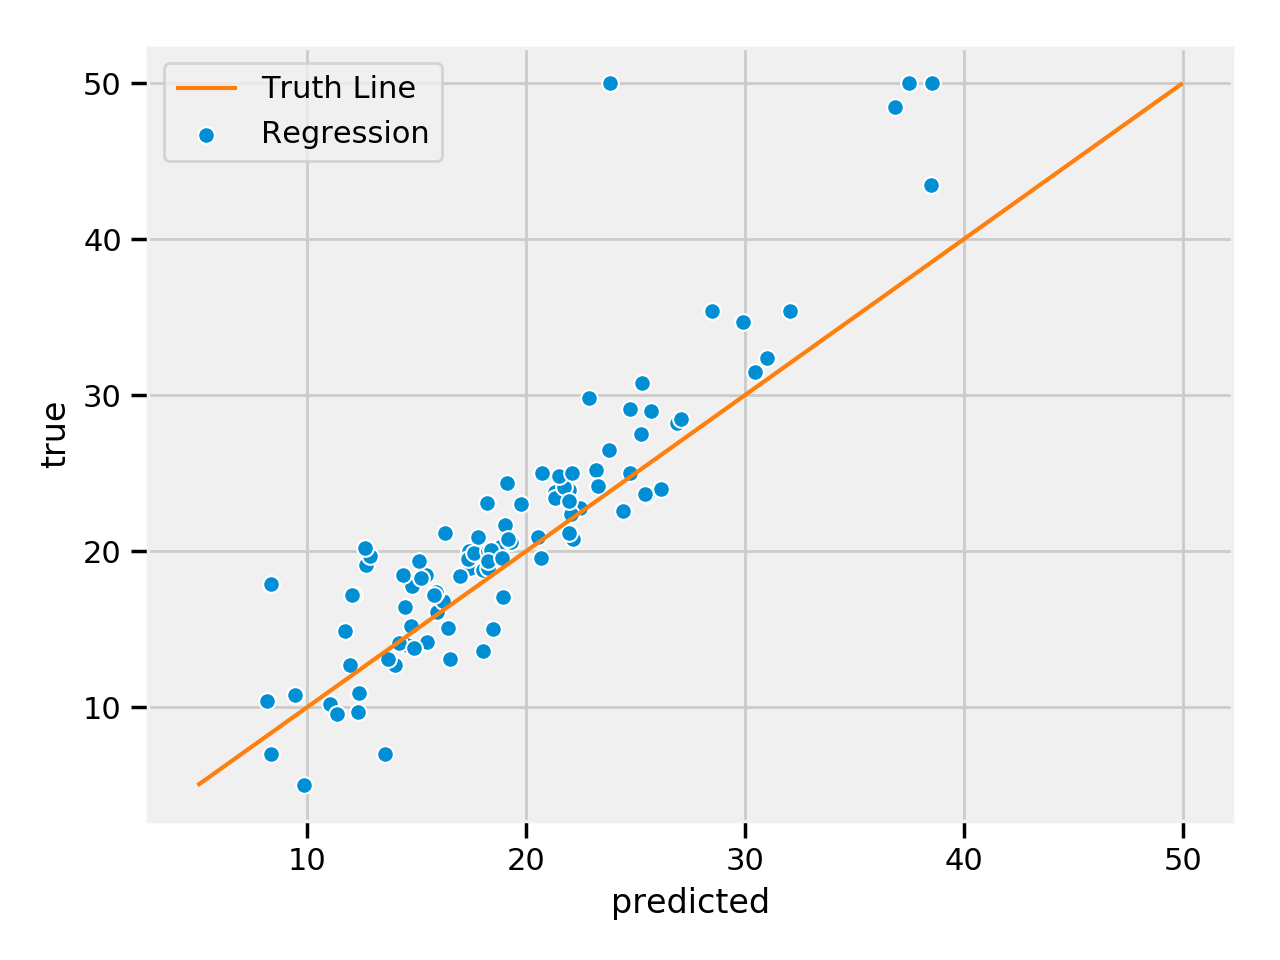

In [249]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

# OLD

In [113]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

The Keras wrapper object for use in scikit-learn as a regression estimator is called KerasRegressor. We create an instance and pass it both the name of the function to create the neural network model as well as some parameters to pass along to the fit() function of the model later, such as the number of epochs and batch size. Both of these are set to sensible defaults.

We also initialize the random number generator with a constant random seed, a process we will repeat for each model evaluated in this tutorial. This is an attempt to ensure we compare models consistently.

In [114]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

The final step is to evaluate this baseline model. We will use 10-fold cross validation to evaluate the model.

In [116]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train_scaled, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

KeyError: '[196 358  86 221 118] not in index'

It is almost always good practice to prepare your data before modeling it using a neural network model.

Continuing on from the above baseline model, we can re-evaluate the same model using a standardized version of the input dataset.

We can use scikit-learn’s Pipeline framework to perform the standardization during the model evaluation process, within each fold of the cross validation. This ensures that there is no data leakage from each testset cross validation fold into the training data.

The code below creates a scikit-learn Pipeline that first standardizes the dataset then creates and evaluate the baseline neural network model.

In [ ]:
# evaluate model with standardized dataset
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

A further extension of this section would be to similarly apply a rescaling to the output variable such as normalizing it to the range of 0-1 and use a Sigmoid or similar activation function on the output layer to narrow output predictions to the same range.

# Evaluate Different network topologies

# Deeper (more layers)

In [ ]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

## Wider

In [ ]:
# define wider model
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

## Both

In [ ]:
# define the model
def combo_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(14, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=combo_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Combo: %.2f (%.2f) MSE" % (results.mean(), results.std()))